# Setup

In [1]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
if IN_COLAB:
    !pip install -q scikit-learn
    !pip install -q einops jaxtyping
    !pip install -q transformers tokenizers
    !pip install -q transformer_lens circuitsvis

In [3]:
from dataclasses import dataclass
import random
import gc
from pathlib import Path
import functools

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

import torch as t
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from scipy.optimize import curve_fit

import einops
from tqdm.notebook import tqdm #progress bars
from typing import Tuple, List, Optional, Dict
from jaxtyping import Float, Int, Bool
from torch import Tensor

from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast

import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output
import circuitsvis as cv

import h5py
import palettable

device = t.device("cuda" if t.cuda.is_available() else "cpu")
if IN_COLAB:
    rootdir=Path('/content/drive/MyDrive/AI/plusminus/')
    traindir = rootdir/'trained_models/'
else:
    rootdir=Path('./')
    traindir=rootdir/'training_data/'
figdir = rootdir/'figures/'
print('using device: ', device)
print('rootdir is: ', rootdir)

using device:  cpu
rootdir is:  .


# Tokenizer

In [4]:
tokenizer = PreTrainedTokenizerFast(tokenizer_file=str(traindir/'tokenizer_2digit.json'), add_bos_token=True, name_or_path='2digit')
vocab = tokenizer.get_vocab()

# Model

In [5]:
@dataclass
class Config():
  d_vocab: int = len(tokenizer.get_vocab().keys())
  d_model: int = len(tokenizer.get_vocab().keys())
  d_mlp: int = 72
  n_heads: int = 8
  d_head: int = 18
  n_ctx: int = 6 #(N)(-)(N)(=)(+/-)(N)
  n_layers: int = 1

def build_hooked_transformer(cfg: Config, attn_only=False, one_hot_encode=True, norm_type='LN', **kwargs):

    hkconfig = HookedTransformerConfig(
        n_layers = cfg.n_layers,
        d_model = cfg.d_model,
        n_ctx = cfg.n_ctx,
        d_head = cfg.d_head,
        n_heads = cfg.n_heads,
        act_fn = 'relu',
        attn_only=attn_only,
        normalization_type=norm_type,
        **kwargs
    )
    model =  HookedTransformer(cfg = hkconfig, tokenizer=tokenizer)

    if attn_only:
        #Remove biases from attention heads for direct comparison with math framework paper.
        for layer in model.blocks:
            layer.attn.b_K.requires_grad = False
            layer.attn.b_O.requires_grad = False
            layer.attn.b_Q.requires_grad = False
            layer.attn.b_V.requires_grad = False

    if one_hot_encode:
        if cfg.d_model != len(tokenizer.get_vocab().keys()):
            raise ValueError("d_model != d_vocab, but that is required for one-hot encoding.")
        model.embed.W_E.requires_grad = False
        model.embed.W_E[:] = t.eye(cfg.d_model, cfg.d_model)
        model.unembed.W_U.requires_grad = False
        model.unembed.b_U.requires_grad = False
        model.unembed.W_U[:] = t.eye(cfg.d_model, cfg.d_model)
    return model

In [6]:
# Model Config
d_vocab = len(tokenizer.get_vocab().keys())
d_model = 128
n_head = 4
d_head = d_model // n_head
d_mlp  = 4 * d_model
n_layers = 1
attn_only = False
one_hot_encode = False
cfg = Config(n_layers=n_layers, d_model=d_model, n_heads=n_head, d_mlp=d_mlp, d_head=d_head)

# Load Model
tfm = build_hooked_transformer(cfg, attn_only=attn_only, one_hot_encode=one_hot_encode, norm_type=None)
tfm.to(device)
tokenizer = tfm.tokenizer
filename = traindir/'mlp_2digit_subtraction_nlayer1_nheads4_dmodel128_dhead32_seed12466689936998274052.pt'
tfm.load_state_dict(t.load(filename, map_location=device))

Moving model to device:  cpu


<All keys matched successfully>

In [7]:
# It's good to define helper variables
W_O = tfm.W_O[0]
W_K = tfm.W_K[0]
W_Q = tfm.W_Q[0]
W_V = tfm.W_V[0]
W_in = tfm.W_in[0]
W_out = tfm.W_out[0]
W_pos = tfm.W_pos
W_E = tfm.W_E
W_U = tfm.W_U

print('W_O  ', tuple(W_O.shape))
print('W_K  ', tuple(W_K.shape))
print('W_Q  ', tuple(W_Q.shape))
print('W_V  ', tuple(W_V.shape))
print('W_in ', tuple(W_in.shape))
print('W_out', tuple(W_out.shape))
print('W_pos', tuple(W_pos.shape))
print('W_E  ', tuple(W_E.shape))
print('W_U  ', tuple(W_U.shape))

W_O   (4, 32, 128)
W_K   (4, 128, 32)
W_Q   (4, 128, 32)
W_V   (4, 128, 32)
W_in  (128, 512)
W_out (512, 128)
W_pos (6, 128)
W_E   (103, 128)
W_U   (128, 103)


# Data

In [8]:
class DataHolder:

    def __init__(self, train_frac=0.3, batch_size=128):

        self.data = self.get_dataset()
        self.strs = self.build_strings(self.data)
        self.tok = self.encode(self.strs)

    def get_dataset(self):
        data = t.Tensor([(i,j) for i in range(100) for j in range(100)])
        results = data[:,:1] - data[:,-1:]
        return t.cat((data, results), dim=1).to(t.int64)

    def build_strings(self, nums: Tensor):
        iterable = zip(nums[:,0], nums[:,1], nums[:,2])
        data = [f'{n1}-{n2}={res:+d}' for n1,n2,res in iterable]
        return data

    def encode(self, str_data):
        return t.Tensor(tokenizer.batch_encode_plus(str_data).input_ids).to(t.int64)

data = DataHolder()
print(data.strs[:10])
print(data.strs[::333], data.tok[::333])

['0-0=+0', '0-1=-1', '0-2=-2', '0-3=-3', '0-4=-4', '0-5=-5', '0-6=-6', '0-7=-7', '0-8=-8', '0-9=-9']
['0-0=+0', '3-33=-30', '6-66=-60', '9-99=-90', '13-32=-19', '16-65=-49', '19-98=-79', '23-31=-8', '26-64=-38', '29-97=-68', '33-30=+3', '36-63=-27', '39-96=-57', '43-29=+14', '46-62=-16', '49-95=-46', '53-28=+25', '56-61=-5', '59-94=-35', '63-27=+36', '66-60=+6', '69-93=-24', '73-26=+47', '76-59=+17', '79-92=-13', '83-25=+58', '86-58=+28', '89-91=-2', '93-24=+69', '96-57=+39', '99-90=+9'] tensor([[  0, 101,   0, 102, 100,   0],
        [  3, 101,  33, 102, 101,  30],
        [  6, 101,  66, 102, 101,  60],
        [  9, 101,  99, 102, 101,  90],
        [ 13, 101,  32, 102, 101,  19],
        [ 16, 101,  65, 102, 101,  49],
        [ 19, 101,  98, 102, 101,  79],
        [ 23, 101,  31, 102, 101,   8],
        [ 26, 101,  64, 102, 101,  38],
        [ 29, 101,  97, 102, 101,  68],
        [ 33, 101,  30, 102, 100,   3],
        [ 36, 101,  63, 102, 101,  27],
        [ 39, 101,  96, 102

# Baseline model performance

In [9]:
def get_accuracy(
    logits: Float[Tensor, "batch posn d_vocab"],
    tokens: Int[Tensor, "batch posn"],
    meandim: int = None
) -> Float[Tensor, "batch posn-1"]:

    logit_preds = logits[:, 3:-1, :].argmax(dim=-1) #5-digit
    acc = (logit_preds == tokens[:, 4:]).to(t.float)
    return acc.mean(dim=meandim)

def get_loss(
    logits: Float[Tensor, "batch posn d_vocab"],
    tokens: Int[Tensor, "batch posn"],
    meandim: int = None
) -> Float[Tensor, "batch posn-1"]:

    log_probs = logits.log_softmax(dim=-1)
    # Get logprobs the first seq_len-1 predictions (so we can compare them with the actual next tokens)
    log_probs_for_tokens = log_probs[:, 3:-1].gather(dim=-1, index=tokens[:, 4:].unsqueeze(-1)).squeeze(-1) #5-digit
    return -log_probs_for_tokens.mean(dim=meandim)


In [10]:
original_logits, cache = tfm.run_with_cache(data.tok)
# Final 2 positions: (+/-) and number. Also remove the logits for `=`
original_loss = get_loss(original_logits, data.tok, meandim=0) #loss by digit
original_acc  = get_accuracy(original_logits, data.tok, meandim=0)
original_logits = original_logits[:, -2:, :-1]
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")

Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%


# Direct logit contributions

Again, MLP is everything.

In [11]:
x0 = cache['resid_pre', 0]
delta_attn = cache['resid_mid', 0] - x0
delta_mlp = cache['resid_post', 0] - x0 - delta_attn

W_U_correct_tokens = W_U[:, data.tok[:,1:]][:,:,4]
direct = einops.einsum(W_U_correct_tokens, x0[:,4,:],
                            "d_model batch, batch d_model -> batch")
attn = einops.einsum(W_U_correct_tokens, delta_attn[:,4,:],
                            "d_model batch, batch d_model -> batch")
mlp = einops.einsum(W_U_correct_tokens, delta_mlp[:,4,:],
                            "d_model batch, batch d_model -> batch")
sum = direct + attn + mlp

print((direct/sum).max())
print((attn/sum).max())
print((mlp/sum).max())

print((direct/sum).min())
print((attn/sum).min())
print((mlp/sum).min())

tensor(0.0122, grad_fn=<MaxBackward1>)
tensor(0.0630, grad_fn=<MaxBackward1>)
tensor(1.0231, grad_fn=<MaxBackward1>)
tensor(-0.0109, grad_fn=<MinBackward1>)
tensor(-0.0267, grad_fn=<MinBackward1>)
tensor(0.9386, grad_fn=<MinBackward1>)


# Important matrices and assumptions

### Q and K Biases don't matter

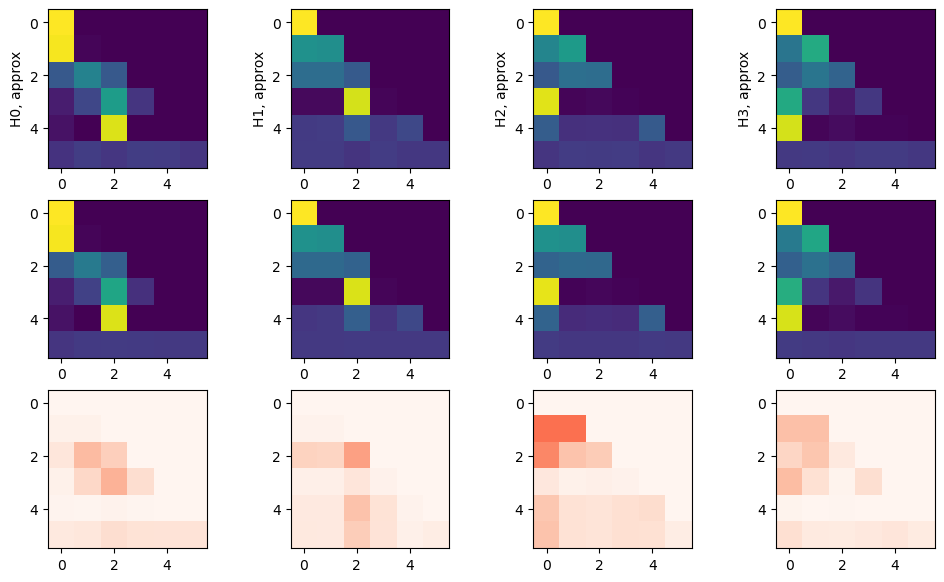

In [12]:
def apply_causal_mask(
        attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"]
    ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
        '''
        Applies a causal mask to attention scores, and returns masked scores.
        '''
        # SOLUTION
        # Define a mask that is True for all positions we want to set probabilities to zero for
        all_ones = t.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device)
        mask = t.triu(all_ones, diagonal=1).bool()
        # Apply the mask to attention scores, then return the masked scores
        attn_scores.masked_fill_(mask, tfm.blocks[0].attn.IGNORE)
        return attn_scores

attn_patt = cache['pattern', 0, 'attn']
x0 = cache['resid_pre', 0]
q = einops.einsum(x0, W_Q, 'batch seq d_model, n_head d_model d_head -> batch seq n_head d_head')# + tfm.b_Q
k = einops.einsum(x0, W_K, 'batch seq d_model, n_head d_model d_head -> batch seq n_head d_head')# + tfm.b_K
qk = einops.einsum(q, k, 'b q nh dh, b k nh dh -> b nh q k')
patt = F.softmax(apply_causal_mask(qk)/np.sqrt(tfm.cfg.d_head), dim=-1)

fig, axs = plt.subplots(3, 4, figsize=(12,7))
for i in range(4):
    axs[0][i].imshow(patt[0,i].detach().numpy(), vmin=0, vmax=1)
    axs[1][i].imshow(attn_patt[0,i].detach().numpy(), vmin=0, vmax=1)
    axs[2][i].imshow(np.sqrt(((attn_patt[:,i] - patt[:,i]).detach().numpy()**2).mean(axis=0)), vmin=0, vmax=1e-1, cmap='Reds')
    axs[0][i].set_ylabel('H{}, approx'.format(i))
    axs[0][i].set_ylabel('H{}, approx'.format(i))

### Can we ablate heads without loss of accuracy? -> Heads 1 and 2 don't contribute to the circuit for predicting the number

In [13]:
def ablate_attn_head(
    attn_patt: Float[Tensor, "batch seq n_head d_head"],
    hook: HookPoint,
    head: int = 0
) -> Float[Tensor, "batch seq n_head d_head"]:
    attn_patt[:,:,head] = t.mean(attn_patt, dim=2).mean(dim=0,keepdim=True)

for i in range(4):
    # print(cache)
    ablate_head = functools.partial(ablate_attn_head, head=i)
    ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                    (utils.get_act_name("blocks.0.attn.hook_z"), ablate_head)
                ])
    ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
    ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)
    
    print('Ablating head {}'.format(i))
    print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
    print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating head 0
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [ 1.3946854 10.801869 ], Ablated acc: [89.69  1.02]%
Ablating head 1
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [3.7781804 0.0292924], Ablated acc: [83.76 99.57]%
Ablating head 2
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [4.074169   0.02018111], Ablated acc: [83.48 99.93]%
Ablating head 3
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [ 1.7944238 11.955465 ], Ablated acc: [89.380005  0.97    ]%


### Modify tokens to account for position
Makes it so that W_neur can be defined with just W_E -- but when we interpret we need to remember that the token is not quite one-hot encoded!!

Well -- sort of. We can break it up into a constant thing that's ALWAYS there, then we can 

In [14]:
W_E_inv = t.Tensor(np.linalg.pinv(W_E.detach().numpy()))

def approx_posembed_hook(
    embedding: Float[Tensor, "batch seq d_model"],
    hook: HookPoint,
) -> Float[Tensor, "batch seq d_model"]:
    embedding[:,:,:] = (einops.einsum(W_pos, W_E_inv, W_E, 'seq imodel, imodel vocab, vocab model -> seq model'))[None,:]


ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("pos_embed"), approx_posembed_hook)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Approximating positional embed]')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Approximating positional embed]
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.0684856  0.01810083], Ablated acc: [98.549995 99.94    ]%


In [15]:
true_tok = t.zeros((data.tok.shape[0], data.tok.shape[1], W_E.shape[0]))
for i,tok in enumerate(data.tok):
    for j, tind in enumerate(tok):
        true_tok[i,j,tind] = 1
position_toks = einops.einsum(tfm.W_pos, W_E_inv, 'seq imodel, imodel vocab -> seq vocab')
mod_tok = true_tok + position_toks

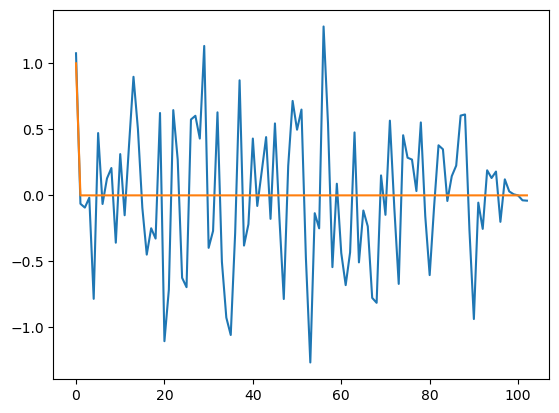

In [16]:
plt.plot(mod_tok[0,0,:].detach().numpy())
plt.plot(true_tok[0,0,:].detach().numpy())

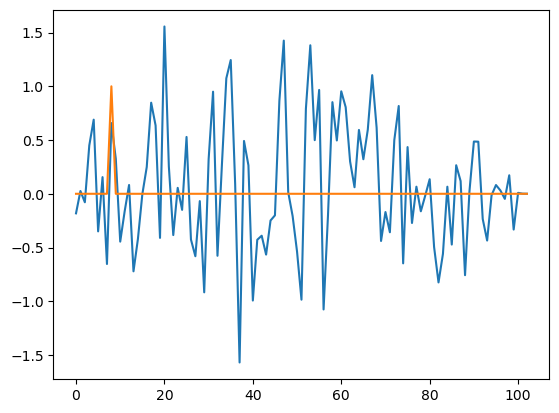

In [17]:
plt.plot(mod_tok[8,2,:].detach().numpy())
plt.plot(true_tok[8,2,:].detach().numpy())

### Do we need any other biases? (b_V, b_O, b_in, b_out)? -> Eh, maybe.

In [18]:
def ablate_bias(
    vals: Float[Tensor, "batch seq n_head d_head"],
    hook: HookPoint
) -> Float[Tensor, "batch seq n_head d_head"]:
    vals -= tfm.b_V

ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.attn.hook_v"), ablate_bias)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating b_V'.format(i))
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating b_V
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.31551954 0.0204126 ], Ablated acc: [95.71 99.94]%


In [19]:
def ablate_bias(
    vals: Float[Tensor, "batch seq d_model"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_model"]:
    vals -= tfm.b_O

ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.hook_attn_out"), ablate_bias)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating b_O'.format(i))
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating b_O
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.08640012 0.01892112], Ablated acc: [98.25 99.94]%


In [20]:
def ablate_bias(
    vals: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    vals -= tfm.b_in

ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), ablate_bias)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating b_in'.format(i))
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating b_in
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.07248662 0.01776718], Ablated acc: [98.36 99.94]%


In [21]:
def ablate_bias(
    vals: Float[Tensor, "batch seq d_model"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_model"]:
    vals -= tfm.b_out

ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.hook_mlp_out"), ablate_bias)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating b_out'.format(i))
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating b_out
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06832373 0.01805187], Ablated acc: [98.57 99.94]%


### Matrix definitions

In [22]:
W_logit = einops.einsum(tfm.W_out[0], tfm.W_U, "d_mlp d_model, d_model d_vocab -> d_mlp d_vocab")
W_neur = einops.einsum(tfm.W_E,tfm.blocks[0].attn.W_V,tfm.blocks[0].attn.W_O, W_in, "d_vocab d_model, head d_model d_attn, head d_attn d_model_out, d_model_out d_mlp -> d_vocab head d_mlp")
# W_neur = einops.einsum(W_E, W_V, W_O, W_in, "d_vocab d_model, n_head d_model d_head, n_head d_head d_model, d_model d_mlp -> n_head d_vocab d_mlp")
W_neur_embed = einops.einsum(W_E, W_in, "d_vocab d_model, d_model d_mlp -> d_vocab d_mlp")
W_neur_pos = einops.einsum(W_pos, W_in, "seq d_model, d_model d_mlp -> seq d_mlp")
W_neur_attn_pos = einops.einsum(W_pos, W_V, W_O, W_in, "seq d_model, n_head d_model d_head, n_head d_head d_model, d_model d_mlp -> n_head seq d_mlp")
# t3 = cache['embed'][0,3,:] + cache['pos_embed'][0,3,:]
# W_attn = einops.einsum(t3, W_Q, W_K, W_E, "d_model, n_head d_model d_head, n_head d_model d_head, d_vocab d_model -> n_head d_vocab") / np.sqrt(cfg.d_head)
# print(W_logit.shape, W_neur.shape, W_attn.shape)

# Attention Patterns

In [23]:
indices = [3310, 9405,1033,594]
prob = indices[0]
toks = data.tok[prob]
tokens = tfm.to_str_tokens(toks)

pattern = cache['pattern', 0, 'attn'][prob]

pattern[0,4,:] = 0 # zero out pattern
neg = t.Tensor([d == tokenizer.get_vocab()['-'] for d in data.tok[:,4]]).to(t.bool)[prob]
pos = t.Tensor([d == tokenizer.get_vocab()['+'] for d in data.tok[:,4]]).to(t.bool)[prob]

#head 0
print(pattern.shape, pos, toks[4])
if toks[4] == tokenizer.get_vocab()['+']:
    pattern[0,4,0] = 0 #does not attend to a when positive
    pattern[0,4,2] = 1 #attends to b when positive
else:
    pattern[0,4,0] = 1 #attends to a when negative
    pattern[0,4,2] = 0 #does not attend to to b when negative

html = cv.attention.attention_patterns(
    tokens=tokens,
    attention=pattern,
)

display(html)

torch.Size([4, 6, 6]) tensor(True) tensor(100)


torch.Size([4, 4, 6, 6])


<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_74560/3209168454.py:14: SyntaxWarning: invalid escape sequence '\p'
  axs[i][j].set_xticks(range(6), ['a', '-', 'b', '=', '$\pm$', 'c'])
/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_74560/3209168454.py:15: SyntaxWarning: invalid escape sequence '\p'
  axs[i][j].set_yticks(range(6), ['a', '-', 'b', '=', '$\pm$', 'c'])


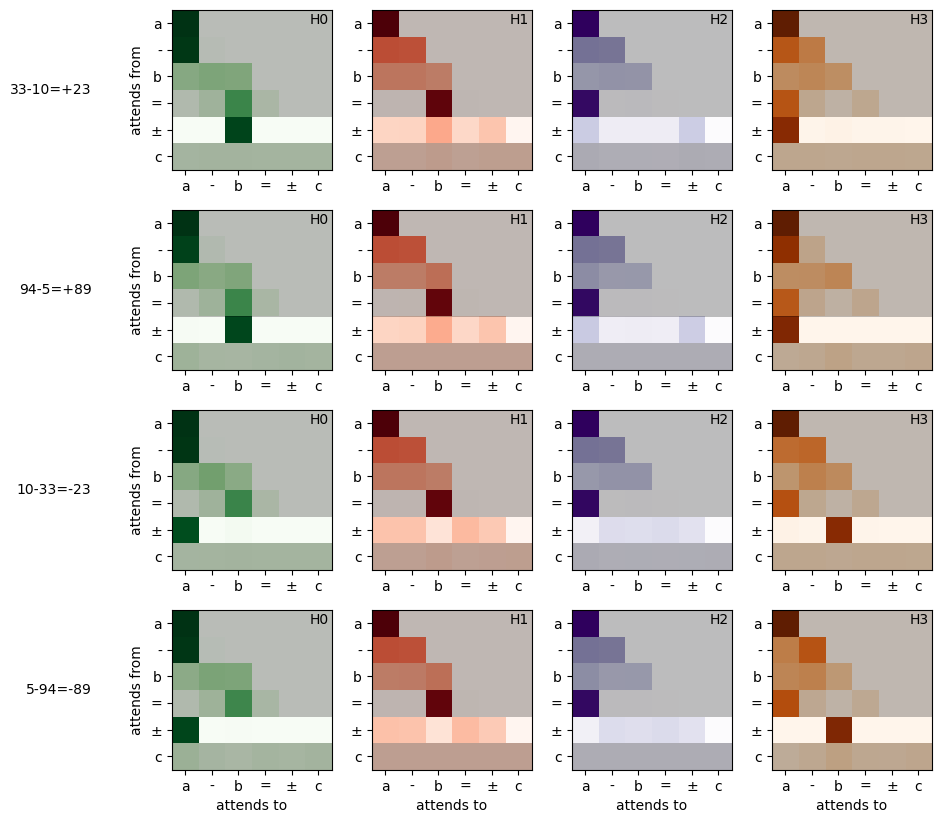

In [24]:

pattern = cache['pattern', 0, 'attn'][indices]
print(pattern.shape)

maps = ['Greens', 'Reds', 'Purples', 'Oranges']

fig = plt.figure(figsize=(10, 8))
axs = []
for i in range(4): #example
    axs.append([])
    for j in range(4): #head
        axs[i].append(fig.add_axes([j*0.2+0.2, 1-(i+1)*0.25, 0.17, 0.2]))
        axs[i][j].imshow(pattern[i,j], cmap=maps[j], vmin=0, vmax=1)
        axs[i][j].text(0.98, 0.98, f'H{j}', transform=axs[i][j].transAxes, ha='right', va='top')
        axs[i][j].set_xticks(range(6), ['a', '-', 'b', '=', '$\pm$', 'c'])
        axs[i][j].set_yticks(range(6), ['a', '-', 'b', '=', '$\pm$', 'c'])
        if j == 0:
            axs[i][j].set_ylabel('attends from')
        if i == 3:
            axs[i][j].set_xlabel('attends to')
        axs[i][j].fill_between((-0.5,5.5), -0.5, 3.51, color='black', alpha=0.25, lw=0)
        axs[i][j].fill_between((-0.5,5.5), 4.49, 5.51, color='black', alpha=0.25, lw=0)
        axs[i][j].set_ylim(5.5, -0.5)
    axs[i][0].text(-0.5, 0.5, ''.join(tfm.to_str_tokens(data.tok[indices[i]])), transform=axs[i][0].transAxes, ha='right', va='center')
fig.savefig(figdir/'attention_head_examples.png',  dpi=300, bbox_inches='tight') 

Heads 0 and 3 'swap' with each other depending on if the outcome is positive or negative!

Head 0 focuses on $a$ when the result is negative and on $b$ when it is positive, and head 3 focuses on $b$ for a negative result and on $a$ for a positive result.

Let's take the example of fixing $b = 30$ and varying $a \in [0,99]$. For $a \in [0,30]$, the result is negative, so head 0 focuses on $a$ and head 3 focuses on $b$. Since $b$ is fixed, head 3 picks out a constant value of e.g., the pink line in the above plots, while head 0 changes along the green line in the plots above. Then the attention heads switch when the result becomes positive, so head 3 focuses on $a$ while head 0 focuses on $b$. Again, $b$ does not change, so that head gives a fixed value of for all cases while head 3 now varies smoothly along the pink lines.

## What is the probability distribution of the attention value of each head at position 0 and 2 on the = sign?

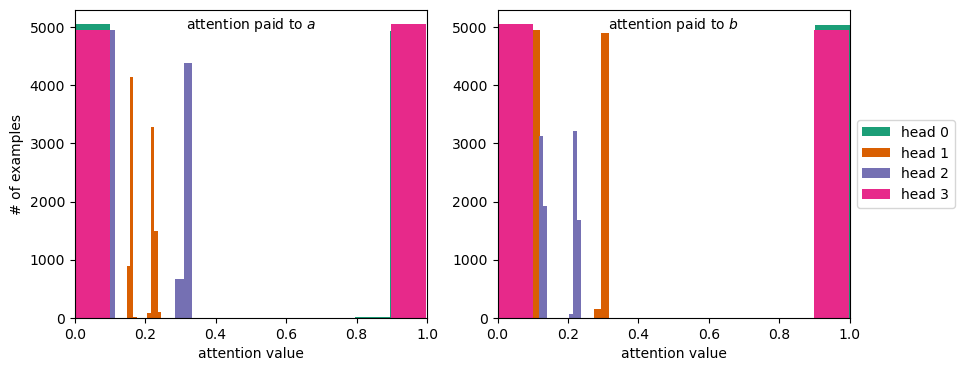

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
for i, ax in enumerate(axs):
    ax.set_prop_cycle('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)
    ax.set_xlabel('attention value')
    axs[i].text(0.5, 0.95, 'attention paid to ${}$'.format('a' if i == 0 else 'b'), transform=axs[i].transAxes, ha='center', va='center')
    ax.set_xlim(0, 1)
    
attn_patt = cache['pattern', 0, 'attn']
attn_on_a = attn_patt[:,:,4,0]
attn_on_b = attn_patt[:,:,4,2]
for i in range(attn_on_a.shape[-1]):
    axs[0].hist(attn_on_a[:,i])
    axs[1].hist(attn_on_b[:,i], label='head {}'.format(i))
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].set_ylabel('# of examples')
fig.savefig(figdir/'attention_hists.png', dpi=300, bbox_inches='tight')

## Analytic description

To first order for token $a$:

* Head 0 attends with a value of 1 for negative sign, else 0
* Head 3 attends with a value of 1 for positive sign, else 0

To first order for token $b$:

* Head 0 attends with a value of 1 for positive sign, else 0
* Head 3 attends with a value of 1 for negative sign, else 0

Heads 1 and 2 do not attend. So:

$
A_{0,a} = \begin{cases} 1 & t_{4} = - \\ 0 & t_{4} = + \end{cases},\qquad
A_{1,a} = 0,\qquad
A_{2,a} = 0,\qquad
A_{3,a} = \begin{cases} 0 & t_{4} = - \\ 1 & t_{4} = + \end{cases},\qquad
$

and

$
A_{0,b} = \begin{cases} 0 & t_{4} = - \\ 1 & t_{4} = + \end{cases},\qquad
A_{1,b} = 0,\qquad
A_{2,b} = 0,\qquad
A_{3,b} = \begin{cases} 1 & t_{4} = - \\ 0 & t_{4} = + \end{cases},
$

In [26]:
def replace_pattern(
    pattern: Float[Tensor, "batch n_head seq seq"],
    hook: HookPoint
) -> Float[Tensor, "batch n_head seq seq"]:
    neg = t.Tensor([d == tokenizer.get_vocab()['-'] for d in data.tok[:,4]]).to(t.bool)
    pos = t.Tensor([d == tokenizer.get_vocab()['+'] for d in data.tok[:,4]]).to(t.bool)

    # print(pattern[0,:,4,:])
    # Zero out attention of all heads
    pattern[:,:,4,:] = 0
    
    #replace head 0
    pattern[pos,0,4,0] = 0 #does not attend to a when positive
    pattern[neg,0,4,0] = 1 #attends to a when negative
    pattern[pos,0,4,2] = 1 #attends to b when positive
    pattern[neg,0,4,2] = 0 #does not attend to to b when negative

    #replace head 3
    pattern[pos,3,4,0] = 1 #positive = attend
    pattern[neg,3,4,0] = 0 #negative = not attend
    pattern[pos,3,4,2] = 0 #positive = not attend
    pattern[neg,3,4,2] = 1 #negative = attend
    # print(pattern[0,:,4,:])
    
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.attn.hook_pattern"), replace_pattern)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('replacing attn pattern')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

replacing attn pattern
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06826339 0.01684669], Ablated acc: [98.549995 99.94    ]%


Indeed, this description plus removing heads 1 and 2 decreases loss!

# How do different tokens / heads contribute to the neurons?

In [27]:
key_freqs = [0.33, 0.39, 0.48]
def fit_neuron_line(x, m, b):
    output = m*x + b
    return output

def fit_neuron_oscillations(x, a1, a2, a3, b1, b2, b3, phi1, phi2, phi3, theta11, theta12, theta21, theta22, theta31, theta32):
    """ This works, but it's messy """
    fitvals = ((a1, phi1, b1, theta11, theta12), (a2, phi2, b2, theta21, theta22), (a3, phi3, b3, theta31, theta32))
    output = np.zeros_like(x, dtype=np.float64)
    for keyf, fit in zip(key_freqs, fitvals):
        a, phi, b, theta1, theta2 = fit
        output += a*np.cos(2*np.pi*keyf*x + phi) + b*np.cos(2*np.pi*keyf*x + theta1)*np.cos(2*np.pi*x/100 + theta2)
    return output

def fit_neuron_full(x, m, b, a1, a2, a3, b1, b2, b3, phi1, phi2, phi3, theta11, theta12, theta21, theta22, theta31, theta32):
    fitvals = ((a1, phi1, b1, theta11, theta12), (a2, phi2, b2, theta21, theta22), (a3, phi3, b3, theta31, theta32))
    output = m*x + b
    for keyf, fit in zip(key_freqs, fitvals):
        a, phi, b, theta1, theta2 = fit
        output += a*np.cos(2*np.pi*keyf*x + phi) + b*np.cos(2*np.pi*keyf*x + theta1)*np.cos(2*np.pi*x/100 + theta2)
    return output

In [28]:

n_points = 100
window = 1
def plot_neuronact(neuron: int):
    clear_output()
    freqs = np.fft.fftfreq(n_points)
    
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    for head in range(4):
        if head in [1, 2]: continue
        guess = [1e-3,]*17
        this_neuron_contrib = W_neur[:n_points,head,neuron].detach().numpy()
        fit, cov = curve_fit(fit_neuron_full, np.arange(n_points), this_neuron_contrib, bounds=(-10,10))
        this_linfit = fit_neuron_line(np.arange(n_points), fit[0], fit[1])
        this_fullfit = fit_neuron_full(np.arange(n_points), *fit)
        
        transform = np.fft.fft(window*(this_neuron_contrib - this_linfit))
        power = (transform*np.conj(transform)).real
        power_pos = np.zeros((freqs >= 0).sum())
        for i,f in enumerate(freqs[freqs >= 0]):
            power_pos[i] = power[np.abs(freqs) == f].sum()

        print('frac variance not explained by fit =', ((this_neuron_contrib - this_fullfit)**2).sum() /  (this_neuron_contrib**2).sum())


        transform2 = np.fft.fft(window*(this_neuron_contrib - this_fullfit))
        power2 = (transform2*np.conj(transform)).real
        power_pos2 = np.zeros((freqs >= 0).sum())
        for i,f in enumerate(freqs[freqs >= 0]):
            power_pos2[i] = power2[np.abs(freqs) == f].sum()
        
        # axs[0].plot(this_neuron_contrib, label = f'head={head}; fit={linfit}')
        if head == 0:
            
            axs[0].plot(this_neuron_contrib, label= f'head={head}')
            axs[0].plot(this_neuron_contrib - this_fullfit, label= f'head={head} - fit')
            axs[1].plot(freqs[freqs >=0], power_pos)
            axs[1].plot(freqs[freqs >=0], power_pos2)
            # axs[1].plot(freqs, transform.real)
            # axs[1].plot(freqs, transform.imag)
    for f in key_freqs:
        axs[1].axvline(f, c='k', lw=0.5)
    axs[0].legend()
    axs[0].axhline(0, c='k')
    axs[0].axvline(50, c='k')
    axs[0].set_xlabel('token')
    axs[0].set_ylabel('neuron pre-activation strength contribution')
    axs[1].set_xlabel('freq')
    axs[1].set_ylabel('power after removing linear trend')
    axs[1].set_yscale('log')
    axs[1].set_ylim(1e-3, 1e5)
    axs[1].set_xlim(0.01, 0.5)
    # axs[1].set_xscale('log')
    axs[1].axvline(0.43)
    # axs[1].plot(freqs[freqs > 0], 0.01*freqs[freqs > 0]**-2)
    axs[1].plot(freqs[freqs > 0], 0.02*(1/(freqs[freqs > 0] - 0.33))**2)
interact(plot_neuronact, neuron=widgets.IntText(value=49, description='Neuron:'))

interactive(children=(IntText(value=49, description='Neuron:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_neuronact(neuron: int)>

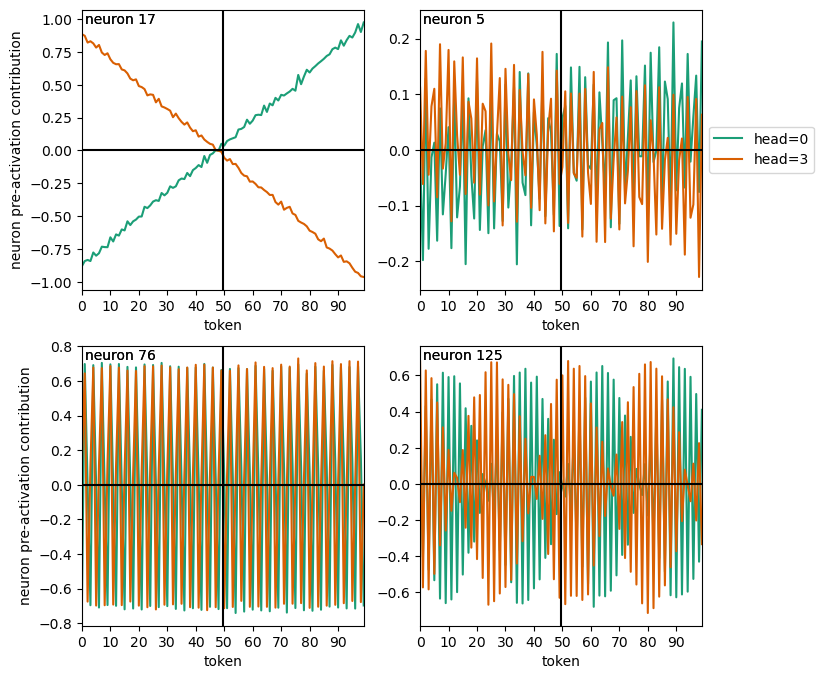

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(8,8))
for i in range(2):
    for j in range(2):
        axs[i][j].set_prop_cycle('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)
for head in range(4):
    if head in [1, 2]: continue
    axs[0][0].plot(W_neur[:100,head,17].detach().numpy(), label = f'head={head}')
    axs[0][1].plot(W_neur[:100,head,5].detach().numpy(), label = f'head={head}')
    axs[1][0].plot(W_neur[:100,head,76].detach().numpy(), label = f'head={head}')
    axs[1][1].plot(W_neur[:100,head,125].detach().numpy(), label = f'head={head}')
    axs[0][0].text(0.01, 0.99, 'neuron 17', ha='left', va='top', transform=axs[0][0].transAxes)
    axs[0][1].text(0.01, 0.99, 'neuron 5', ha='left', va='top', transform=axs[0][1].transAxes)
    axs[1][0].text(0.01, 0.99, 'neuron 76', ha='left', va='top', transform=axs[1][0].transAxes)
    axs[1][1].text(0.01, 0.99, 'neuron 125', ha='left', va='top', transform=axs[1][1].transAxes)
axs[0][1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
for i in range(2):
    for j in range(2):
        axs[i][j].axhline(0, c='k')
        axs[i][j].axvline(49.5, c='k')
        axs[i][j].set_xticks([i*10 for i in range(10)])
        axs[i][j].set_xlim(0, 99)
        axs[i][j].set_xlabel('token')
axs[0][0].set_ylabel('neuron pre-activation contribution')
axs[1][0].set_ylabel('neuron pre-activation contribution')
fig.savefig(figdir/'token_attention_neuron_contributions.png', dpi=300, bbox_inches='tight')

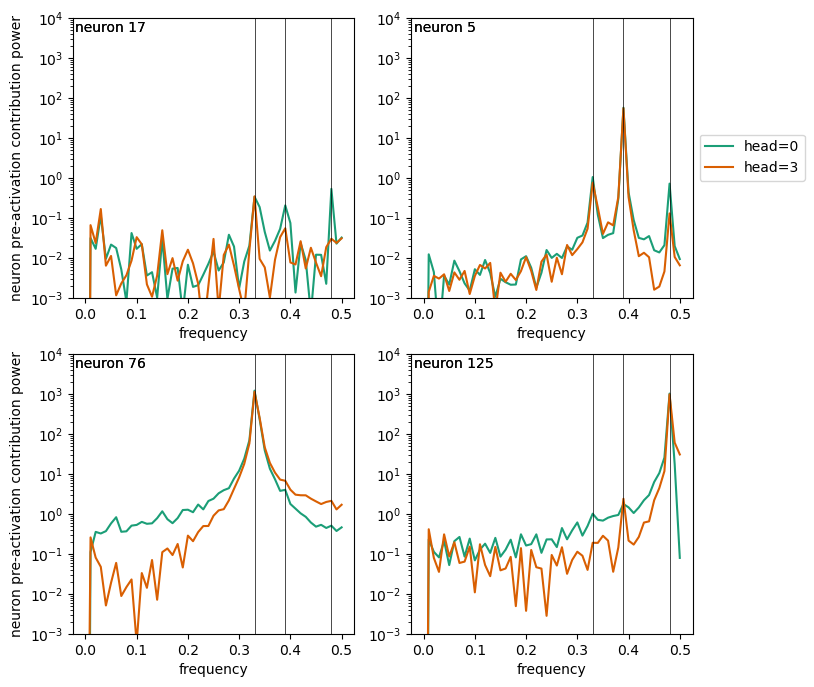

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(8,8))
for i in range(2):
    for j in range(2):
        axs[i][j].set_prop_cycle('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)
for head in range(4):
    if head in [1, 2]: continue
    freqs = np.fft.rfftfreq(100)
    fts = []
    for neuron in [17, 5, 76, 125]:
        linefit, cov = curve_fit(fit_neuron_line, np.arange(100), W_neur[:100,head,neuron].detach().numpy(), bounds=(-10,10))
        fts.append(np.fft.rfft(W_neur[:100,head,neuron].detach().numpy() - fit_neuron_line(np.arange(100), *linefit)))
    axs[0][0].plot(freqs, (fts[0]*np.conj(fts[0])).real, label = f'head={head}')
    axs[0][1].plot(freqs, (fts[1]*np.conj(fts[1])).real, label = f'head={head}')
    axs[1][0].plot(freqs, (fts[2]*np.conj(fts[2])).real, label = f'head={head}')
    axs[1][1].plot(freqs, (fts[3]*np.conj(fts[3])).real, label = f'head={head}')
    axs[0][0].text(0.01, 0.99, 'neuron 17', ha='left', va='top', transform=axs[0][0].transAxes)
    axs[0][1].text(0.01, 0.99, 'neuron 5', ha='left', va='top', transform=axs[0][1].transAxes)
    axs[1][0].text(0.01, 0.99, 'neuron 76', ha='left', va='top', transform=axs[1][0].transAxes)
    axs[1][1].text(0.01, 0.99, 'neuron 125', ha='left', va='top', transform=axs[1][1].transAxes)
axs[0][1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
for i in range(2):
    for j in range(2):
    #     axs[i][j].axhline(0, c='k')
    #     axs[i][j].axvline(49.5, c='k')
        # axs[i][j].set_xticks([i*10 for i in range(10)])
        # axs[i][j].set_xlim(0, 99)
        axs[i][j].set_xlabel('frequency')
        for freq in key_freqs:
            axs[i][j].axvline(freq, c='k', lw=0.5)
        axs[i][j].set_yscale('log')
        axs[i][j].set_ylim(1e-3, 1e4)
axs[0][0].set_ylabel('neuron pre-activation contribution power')
axs[1][0].set_ylabel('neuron pre-activation contribution power')
fig.savefig(figdir/'token_attention_neuron_contributions_freqspace.png', dpi=300, bbox_inches='tight')

So each head can be described as a lienar fit plus a sum of sinusoidal terms over the three key frequencies (with some amplitude and phase).

This means there are 8 fit components for each head: slope, intercept, amplitude x3, phase x3 -- let's fit those and plot those components.

### What are the fits?

In [31]:
var_exp = []
fits = []
for neuron in range(tfm.cfg.d_mlp):
    # print(neuron)
    variance_explained = []
    thesefits = []
    for head in range(4):
        guess = [1e-2,]*8
        this_neuron_contrib = W_neur[:100,head,neuron].detach().numpy()
        fit, cov = curve_fit(fit_neuron_full, np.arange(100), this_neuron_contrib, bounds=(-10,10))
        # print(fit)
        this_linfit = fit[0]*np.arange(100) + fit[1]
        this_fullfit = fit_neuron_full(np.arange(100), *fit)
    
        thesefits.append(fit)
        var = (this_neuron_contrib**2).sum()
        nofit_var = ((this_neuron_contrib - this_fullfit)**2).sum()
        variance_explained.append((1 - nofit_var/var))
    var_exp.append(variance_explained)
    fits.append(thesefits)
fits = np.array(fits)
var_exp = np.array(var_exp)
print('average fraction of variance explained: ', var_exp.mean(axis=0))
print(fits.shape)
fitfuncs = np.zeros((tfm.cfg.d_mlp, tfm.cfg.n_heads, 100))
for i in range(tfm.cfg.d_mlp):
    for j in range(tfm.cfg.n_heads):
        # if i == 3:
        #     print(fits[i,j])
        fitfuncs[i,j,:] = fit_neuron_full(np.arange(100), *fits[i,j])

average fraction of variance explained:  [0.97340139 0.90346416 0.82808362 0.9732194 ]
(512, 4, 17)


So these fits explain > 97% of the variance of head 0 and 3.

## What if we replace pre-activations with these fits?

In [32]:
# The embedding is important to the pre-activations
def replace_resid(
    residual: Float[Tensor, "batch seq d_model"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_model"]:
    residual -= cache['resid_pre', 0]
    
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.hook_resid_mid"), replace_resid)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('removing resid_pre from resid_mid')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

removing resid_pre from resid_mid
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.49822667 5.817159  ], Ablated acc: [89.880005 14.54    ]%


In [33]:
# The embedding is important to the pre-activations (here we re-insert it)
def replace_resid(
    residual: Float[Tensor, "batch seq d_model"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_model"]:
    residual -= cache['resid_pre', 0]

def replace_neurons(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    neg = t.Tensor([d == tokenizer.get_vocab()['-'] for d in data.tok[:,4]]).to(t.bool)
    pos = t.Tensor([d == tokenizer.get_vocab()['+'] for d in data.tok[:,4]]).to(t.bool)
    neurons[pos,4,:] += W_neur_embed[tokenizer.get_vocab()['+']][None,:]
    neurons[neg,4,:] += W_neur_embed[tokenizer.get_vocab()['-']][None,:]
    neurons += W_neur_pos[None,:]
    
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.hook_resid_mid"), replace_resid),
                (utils.get_act_name("blocks.0.mlp.hook_pre"), replace_neurons)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('removing resid_pre from resid_mid, and reinserting in neuron')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

removing resid_pre from resid_mid, and reinserting in neuron
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.09629014 0.01812116], Ablated acc: [98.25 99.94]%


In [34]:
neg = t.Tensor([d == tokenizer.get_vocab()['-'] for d in data.tok[:,4]]).to(t.bool)
pos = t.Tensor([d == tokenizer.get_vocab()['+'] for d in data.tok[:,4]]).to(t.bool)
def replace_pattern(
    pattern: Float[Tensor, "batch n_head seq seq"],
    hook: HookPoint
) -> Float[Tensor, "batch n_head seq seq"]:
    # Zero out attention of all heads
    pattern[:,:,4,:] = 0
    
    #replace head 0
    pattern[:,0,4,0] = 0 #does not attend to a when positive
    pattern[:,0,4,2] = 1 #attends to b when positive

    #replace head 3
    pattern[:,3,4,0] = 1 #positive = attend
    pattern[:,3,4,2] = 0 #positive = not attend

def replace_attn_result(
    result: Float[Tensor, "batch pos d_model"],
    hook: HookPoint
) -> Float[Tensor, "batch pos d_model"]:
    x0 = cache['resid_pre',0][:1]

    result[:,4,:] = einops.einsum(x0,tfm.blocks[0].attn.W_V,tfm.blocks[0].attn.W_O, "batch seq d_model, n_head d_model d_attn, n_head d_attn d_model_out -> batch seq n_head d_model_out")[:,2,0,:]
    result[:,4,:] += einops.einsum(x0,tfm.blocks[0].attn.W_V,tfm.blocks[0].attn.W_O, "batch seq d_model, n_head d_model d_attn, n_head d_attn d_model_out -> batch seq n_head d_model_out")[:,0,3,:] 

def replace_neurons(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:

    NO_INTERVENE = False
    TRUE_SOLN = False
    APPROX_X0 = False
    APPROX_DX = False
    APPROX_ALL = False
    APPROX_WNEUR = False
    USE_FITS = True
    if NO_INTERVENE: return

    pos_embed = cache['pos_embed']
    x0 = cache['resid_pre',0]
    x0_approx = W_E[data.tok]
    x1 = cache['resid_mid',0]
    dx_attn =  x1 - x0

    #approximate x0 by removing positional embedding, then pass that through OV circuit
    dx_attn_approx = einops.einsum(x0_approx,tfm.blocks[0].attn.W_V,tfm.blocks[0].attn.W_O, "batch seq d_model, n_head d_model d_attn, n_head d_attn d_model_out -> batch seq n_head d_model_out")[:,2,0,:] #just keep positive later
    dx_attn_approx[neg] = einops.einsum(x0_approx,tfm.blocks[0].attn.W_V,tfm.blocks[0].attn.W_O, "batch seq d_model, n_head d_model d_attn, n_head d_attn d_model_out -> batch seq n_head d_model_out")[neg,2,3,:]
    dx_attn_approx[pos] += einops.einsum(x0_approx,tfm.blocks[0].attn.W_V,tfm.blocks[0].attn.W_O, "batch seq d_model, n_head d_model d_attn, n_head d_attn d_model_out -> batch seq n_head d_model_out")[pos,0,3,:] 
    dx_attn_approx[neg] += einops.einsum(x0_approx,tfm.blocks[0].attn.W_V,tfm.blocks[0].attn.W_O, "batch seq d_model, n_head d_model d_attn, n_head d_attn d_model_out -> batch seq n_head d_model_out")[neg,0,0,:] 
    dx_attn_approx += tfm.blocks[0].attn.b_O # This is important and was being neglected by my previous attempt
    dx_attn_approx += einops.einsum(tfm.blocks[0].attn.b_V,tfm.blocks[0].attn.W_O,"n_head d_head, n_head d_head d_model -> d_model")
    
    if TRUE_SOLN:
        neurons[:,4,:] = einops.einsum(x1, W_in, 'batch seq d_model, d_model d_mlp -> batch seq d_mlp')[:,4,:]
    elif APPROX_X0:
        neurons[:,4,:] = einops.einsum(dx_attn, W_in, 'batch seq d_model, d_model d_mlp -> batch seq d_mlp')[:,4,:]
        neurons[pos,4,:] += W_neur_embed[tokenizer.get_vocab()['+']]
        neurons[neg,4,:] += W_neur_embed[tokenizer.get_vocab()['-']] # seems to have same action as '+'
        neurons[:,4,:] += W_neur_pos[4,:]
    elif APPROX_DX:
        neurons[:,4,:] = einops.einsum(dx_attn_approx, W_in, 'batch d_model, d_model d_mlp -> batch d_mlp')[:,:]

        # Terms from x0
        neurons[pos,4,:] += W_neur_embed[tokenizer.get_vocab()['+']]
        neurons[neg,4,:] += W_neur_embed[tokenizer.get_vocab()['-']] # seems to have same action as '+'
        neurons[:,4,:] += W_neur_pos[4,:]
    elif APPROX_ALL:
        neurons[pos,4,:] = einops.einsum(x0_approx[:,2],tfm.blocks[0].attn.W_V[0],tfm.blocks[0].attn.W_O[0], W_in, "batch d_model, d_model d_attn, d_attn d_model_out, d_model_out d_mlp -> batch d_mlp")[pos]
        neurons[pos,4,:] += einops.einsum(x0_approx[:,0],tfm.blocks[0].attn.W_V[3],tfm.blocks[0].attn.W_O[3], W_in, "batch d_model, d_model d_attn, d_attn d_model_out, d_model_out d_mlp -> batch d_mlp")[pos]
        neurons[neg,4,:] = einops.einsum(x0_approx[:,2],tfm.blocks[0].attn.W_V[3],tfm.blocks[0].attn.W_O[3], W_in, "batch d_model, d_model d_attn, d_attn d_model_out, d_model_out d_mlp -> batch d_mlp")[neg]
        neurons[neg,4,:] += einops.einsum(x0_approx[:,0],tfm.blocks[0].attn.W_V[0],tfm.blocks[0].attn.W_O[0], W_in, "batch d_model, d_model d_attn, d_attn d_model_out, d_model_out d_mlp -> batch d_mlp")[neg]

        #important bias term from output of attn -> input of MLP
        neurons[:,4,:] += einops.einsum(tfm.blocks[0].attn.b_O, W_in, "d_model, d_model d_mlp -> d_mlp")[None,:]
        neurons[:,4,:] += einops.einsum(tfm.blocks[0].attn.b_V,tfm.blocks[0].attn.W_O, W_in, "n_head d_head, n_head d_head d_model, d_model d_mlp -> d_mlp")

        # Terms from x0
        neurons[pos,4,:] += W_neur_embed[tokenizer.get_vocab()['+']]
        neurons[neg,4,:] += W_neur_embed[tokenizer.get_vocab()['-']] # seems to have same action as '+'
        neurons[:,4,:] += W_neur_pos[4,:]
    elif APPROX_WNEUR:
        neur_contribs = W_neur[data.tok]
        
        neurons[pos,4,:] = neur_contribs[pos,2,0,:]
        neurons[pos,4,:] += neur_contribs[pos,0,3,:]
        neurons[neg,4,:] = neur_contribs[neg,2,3,:]
        neurons[neg,4,:] += neur_contribs[neg,0,0,:]
        
        #important bias term from output of attn -> input of MLP
        neurons[:,4,:] += einops.einsum(tfm.blocks[0].attn.b_O, W_in, "d_model, d_model d_mlp -> d_mlp")[None,:]
        neurons[:,4,:] += einops.einsum(tfm.blocks[0].attn.b_V,tfm.blocks[0].attn.W_O, W_in, "n_head d_head, n_head d_head d_model, d_model d_mlp -> d_mlp")

        # Terms from x0
        neurons[pos,4,:] += W_neur_embed[tokenizer.get_vocab()['+']]
        neurons[neg,4,:] += W_neur_embed[tokenizer.get_vocab()['-']] # seems to have same action as '+'
        neurons[:,4,:] += W_neur_pos[4,:]
    elif USE_FITS:
        for i in range(data.tok.shape[0]):
            if pos[i]:
                neurons[i,4,:] = t.Tensor(fitfuncs[:,0,data.tok[i,2]])
                neurons[i,4,:] += t.Tensor(fitfuncs[:,3,data.tok[i,0]])
            elif neg[i]:
                neurons[i,4,:] = t.Tensor(fitfuncs[:,3,data.tok[i,2]])
                neurons[i,4,:] += t.Tensor(fitfuncs[:,0,data.tok[i,0]])
            
        #important bias term from output of attn -> input of MLP
        # neurons[:,4,:] += einops.einsum(tfm.blocks[0].attn.b_O, W_in, "d_model, d_model d_mlp -> d_mlp")[None,:] #this one doesn't seem too important.
        neurons[:,4,:] += einops.einsum(tfm.blocks[0].attn.b_V,tfm.blocks[0].attn.W_O, W_in, "n_head d_head, n_head d_head d_model, d_model d_mlp -> d_mlp")

        # Terms from x0
        neurons[pos,4,:] += W_neur_embed[tokenizer.get_vocab()['+']]
        neurons[neg,4,:] += W_neur_embed[tokenizer.get_vocab()['-']] # seems to have same action as '+'
        neurons[:,4,:] += W_neur_pos[4,:]

ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), replace_neurons)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('replacing neurons')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

replacing neurons
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06826339 0.03411574], Ablated acc: [98.549995 99.68    ]%


# Neuron Activations
We're going to fit a function of the form $n(a,b) = \text{const} + m(a-b) + a1 \cos(\omega_1 a + p1) + a2 \cos(\omega_1 b + p2)$ to the preactivations in a square where $a > b$, then use that fit to fill in where $b > a$. We'll see how much of each neuron's activation power this describes.

In [35]:
attn_mat = cache['pattern', 0, 'attn'][:,:,-2,:]
neuron_acts_pre = cache['blocks.0.mlp.hook_pre'][:,-2]
neuron_acts_post = cache['blocks.0.mlp.hook_post'][:,-2]
print(neuron_acts_post.shape)
neuron_acts_post_sq = einops.rearrange(neuron_acts_post, "(x y) d_mlp -> x y d_mlp", x=100)
neuron_acts_pre_sq = einops.rearrange(neuron_acts_pre, "(x y) d_mlp -> x y d_mlp", x=100)

torch.Size([10000, 512])


In [36]:
dominant_freq = []
for i in range(tfm.cfg.d_mlp):
    this_data = neuron_acts_post_sq.detach().numpy()[:,:,i]
    freqs = np.fft.fftfreq(100)
    ft2d = np.fft.fft2(this_data)
    power = (ft2d*np.conj(ft2d)).real
    these_powfracs = []
    for freq in key_freqs:
        indices = np.where(np.abs(freqs) == freq)
        mask = np.zeros_like(power, dtype=bool)
        mask[indices,:] = True
        mask[:,indices] = True
        these_powfracs.append(power[mask].sum()/power.sum())
    dominant_freq.append(key_freqs[np.argmax(these_powfracs)])
# print(dominant_freq)


In [37]:
dominant_freq_popts = []
avals = np.arange(100, dtype=float)
bvals = np.arange(100, dtype=float)
bb, aa = np.meshgrid(bvals, avals)

for i, f1 in zip(range(tfm.cfg.d_mlp), dominant_freq):
    def fit_one_freq(data, const, slope, amp1, amp2, p1, p2):
        a, b = data
        om = 2*np.pi*f1
        return const + slope*(a-b) + amp1*np.cos(om*a + p1) + amp2*np.cos(om*b + p2)
        
    preactivation = neuron_acts_pre_sq.detach().numpy()[:,:,i]
    #get upper left corner where a >= b a goes 50-99, b goes 0-49
    good_square = preactivation[50:,:50]
    avals = aa[50:, :50]
    bvals = bb[50:, :50]
    popt, pcov = curve_fit(fit_one_freq, (avals.ravel(), bvals.ravel()), good_square.ravel())
    dominant_freq_popts.append(popt)

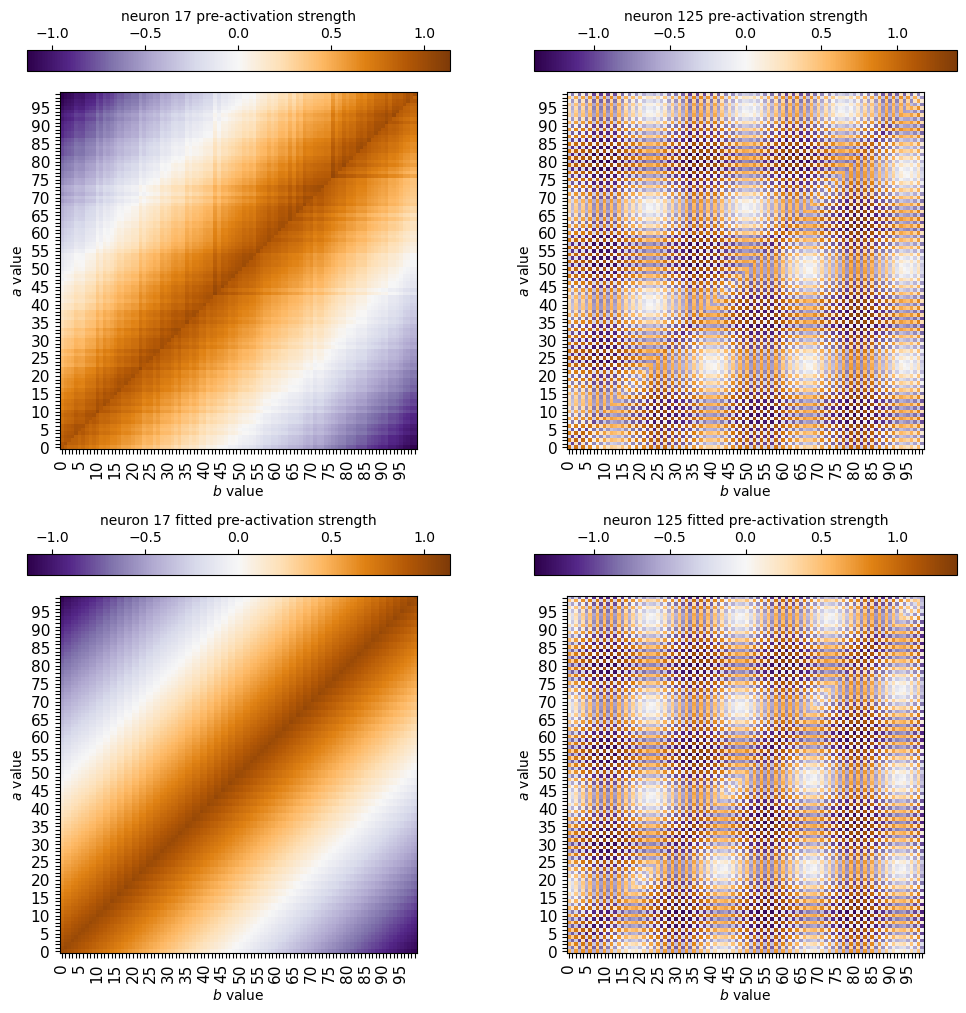

In [38]:
#plot sample neurons

fig, axs = plt.subplots(2, 2, figsize=(12,12))

neurons = [17, 125]
for i, n in enumerate(neurons):
    neur = neuron_acts_pre_sq.detach().numpy()[:,:,n]
    minmax = np.abs(neur).max()
    plot = axs[0][i].imshow(neur, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} pre-activation strength'.format(n))
    axs[0][i].set_ylim(-0.5, 99.5)
    axs[0][i].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[0][i].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
    axs[0][i].set_xlabel(r'$b$ value')
    axs[0][i].set_ylabel(r'$a$ value')

for i, n in enumerate(neurons):
    neur = neuron_acts_pre_sq.detach().numpy()[:,:,n]
    minmax = np.abs(neur).max()
    
    f1 = dominant_freq[n]
    def fit_one_freq(data, const, slope, amp1, amp2, p1, p2):
        a, b = data
        om = 2*np.pi*f1
        return const + slope*(a-b) + amp1*np.cos(om*a + p1) + amp2*np.cos(om*b + p2)
    neur = fit_one_freq((aa,bb), *dominant_freq_popts[n])

    for j in range(100):
        for k in range(100):
            if k > j:  #if b > a -> set answer to same thing where a > b
                neur[j,k] = neur[k,j] #This is what the neuron is actually doing.

    plot = axs[1][i].imshow(neur, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} fitted pre-activation strength'.format(n))
    axs[1][i].set_ylim(-0.5, 99.5)
    axs[1][i].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[1][i].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
    axs[1][i].set_xlabel(r'$b$ value')
    axs[1][i].set_ylabel(r'$a$ value')

fig.savefig(figdir/'sample_neuron_preactivations.png', dpi=300)

In [39]:
# replace all neurons with simple fit
neuron_approx = t.zeros_like(neuron_acts_post)

def replace_neurons(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    for f1,ind,popt in zip(dominant_freq, range(tfm.cfg.d_mlp), dominant_freq_popts):
        def fit_one_freq(data, const, slope, amp1, amp2, p1, p2):
            a, b = data
            om = 2*np.pi*f1
            return const + slope*(a-b) + amp1*np.cos(om*a + p1) + amp2*np.cos(om*b + p2)
        
        new_data = t.Tensor(fit_one_freq((aa,bb), *popt))
        new_data[new_data < 0] = 0
        
        for i in range(100):
            for j in range(100):
                if j > i:  #if b > a -> set answer to same thing where a > b
                    new_data[i,j] = new_data[j,i] #This is what the neuron is actually doing.
        
        neurons[:,4,ind] = new_data.ravel()
    neuron_approx[:] = neurons[:,4,:]

ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), replace_neurons),
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('replacing neurons')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

replacing neurons
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06826339 0.02218409], Ablated acc: [98.549995 99.92    ]%


In [40]:
variance_approx_removed = ((neuron_acts_post - neuron_approx)**2).sum()
variance_neurons = (neuron_acts_post**2).sum()
print('frac removed: ', variance_approx_removed / variance_neurons)

frac removed:  tensor(0.0491, grad_fn=<DivBackward0>)


So this simple fit for the neurons accounts for 95% of the variability and doesn't affect loss much!

In [41]:
def plot_neuronact(pos: int):
    clear_output()
    f1 = dominant_freq[pos]
    popt = dominant_freq_popts[pos]
    def fit_one_freq(data, const, slope, amp1, amp2, p1, p2):
        a, b = data
        om = 2*np.pi*f1
        return const + slope*(a-b) + amp1*np.cos(om*a + p1) + amp2*np.cos(om*b + p2)
    
    def fit_cross_freq(data, amp3):
        const, slope, amp1, amp2, p1, p2 = popt
        p3,p4 = p1,p2
        a, b = data
        om = 2*np.pi*f1
        return amp1*np.cos(om*a + p1)/2 + amp2*np.cos(om*b + p2)/2 + amp3*np.cos(om*a + p3)*np.cos(om*b + p4)

        
    
    # Just get sinusoidal part
    fullfit = fit_one_freq( (aa,bb), *popt)
    linfit = popt[0] + popt[1]*(aa-bb)
    fullfit -= linfit
    fullfit[fullfit < 0] = 0
    
    act_popt, cov = curve_fit(fit_cross_freq, (aa.ravel(), bb.ravel()), fullfit.ravel())
    act_popt[0] *= 2*np.pi
    actfit = fit_cross_freq((aa,bb), *act_popt)
    
    
    #Attempt to reconstruct linear part
    linfit[linfit < 0] = 0
    actfit += linfit
    # actfit[actfit < 0] = 0
    
    #Reconstruct
    fullfit = fit_one_freq( (aa,bb), *popt)
    fullfit[fullfit < 0] = 0
    
    
    fig, axs = plt.subplots(2,2, figsize=(8,8))
    axs[0][0].imshow(fullfit, vmin=0, vmax=fullfit.max())
    axs[0][1].imshow(actfit, vmin=0, vmax=fullfit.max())
    ft = np.fft.fft2(fullfit)
    power = (ft*np.conj(ft)).real
    power[power == 0] = 1e-8
    maxval = np.log10(power).max()
    fullpow = power[30:-30,30:-30].sum()
    axs[1][0].imshow(np.log10(power), vmax=maxval-1, vmin=maxval-4)
    
    ft = np.fft.fft2(actfit)
    power = (ft*np.conj(ft)).real
    power[power == 0] = 1e-8
    actpow = power[30:-30,30:-30].sum()
    axs[1][1].imshow(np.log10(power), vmax=maxval-1, vmin=maxval-4)

    print('power in cross freqs recovered:', actpow/fullpow)
    print('variance explained:', ((actfit)**2).sum()/(fullfit**2).sum())
    print(popt[2:])
    print(act_popt)
    # print(approx_act_popt)
    
    
interact(plot_neuronact, pos=widgets.IntText(value=0, description='Index:'))

i = 0
preactivation = neuron_acts_pre_sq.detach().numpy()[:,:,i]



interactive(children=(IntText(value=0, description='Index:'), Output()), _dom_classes=('widget-interact',))

In [42]:
# replace all neurons with simple fit
neuron_approx = t.zeros_like(neuron_acts_post)

def replace_neurons(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    for f1,ind,popt in zip(dominant_freq, range(tfm.cfg.d_mlp), dominant_freq_popts):
        def fit_one_freq(data, const, slope, amp1, amp2, p1, p2):
            a, b = data
            om = 2*np.pi*f1
            return const + slope*(a-b) + amp1*np.cos(om*a + p1) + amp2*np.cos(om*b + p2)
        
        def fit_cross_freq(data, amp3):
            const, slope, amp1, amp2, p1, p2 = popt
            p3,p4 = p1,p2
            a, b = data
            om = 2*np.pi*f1
            return amp1*np.cos(om*a + p1)/2 + amp2*np.cos(om*b + p2)/2 + amp3*np.cos(om*a + p3)*np.cos(om*b + p4)
    
        
        # Just get sinusoidal part
        fullfit = fit_one_freq( (aa,bb), *popt)
        linfit = popt[0] + popt[1]*(aa-bb)
        
        fullfit -= linfit
        pre_fullfit = t.clone(t.Tensor(fullfit))
        fullfit[fullfit < 0] = 0
        act_popt, cov = curve_fit(fit_cross_freq, (aa.ravel(), bb.ravel()), fullfit.ravel())
        act_popt[0] *= 2*np.pi
        new_data = t.Tensor(fit_cross_freq((aa,bb), *act_popt))
        linfit[linfit < 0] = 0
        new_data += linfit
        
        # new_data = t.Tensor(np.fft.ifft2(ft))
        for i in range(100):
            for j in range(100):
                if j > i:  #if b > a -> set answer to same thing where a > b
                    new_data[i,j] = new_data[j,i] #This is what the neuron is actually doing.
        
        neurons[:,4,ind] = new_data.ravel()
    neuron_approx[:] = neurons[:,4,:]

ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_post"), replace_neurons),
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('replacing neurons')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

replacing neurons
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06826339 0.09108958], Ablated acc: [98.549995 98.79    ]%


# Logits

In [43]:
orig_logits = tfm(data.tok)
original_logits_sq = einops.rearrange(orig_logits, "(x y) seq d_vocab -> x y seq d_vocab", x=100)
log_probs_sq = original_logits_sq.log_softmax(dim=-1)
print(original_logits_sq.shape)

torch.Size([100, 100, 6, 103])


### What do the logits look like?

In [44]:
vmin = -50
vmax =  50

def plot_logit(token: int):
    clear_output()
    data = original_logits_sq.detach().numpy()[:,:,4]
    ft2d = np.fft.fft2(data)
    power = (ft2d*np.conj(ft2d)).real
    freqs = np.fft.fftfreq(100)

    this_token = tokenizer.get_vocab()[str(token)]

    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    minmax = np.abs(data).max()
    plot = axs[0].imshow(data[:,:,this_token], cmap='RdBu_r', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(plot, fraction=0.1, location='top', orientation='horizontal')
    cbar.set_label(r'Logit value ($\ell_+$)')
    axs[0].set_ylim(-0.5, 99.5)
    axs[0].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[0].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
    axs[0].set_ylabel('$a$ value')
    axs[0].set_xlabel('$b$ value')

    thisminmax=np.log10(power)[:,:,this_token].max()
    plot = axs[1].imshow(np.log10(power)[:,:,this_token], cmap='magma', vmax=thisminmax, vmin=thisminmax-4)
    cbar = plt.colorbar(plot, fraction=0.1, location='top', orientation='horizontal')
    cbar.set_label(r'log10 Power of Logit value ($\ell_-$)')
    axs[1].set_ylim(-0.5, 99.5)
    axs[1].set_yticks(range(100));
    axs[1].set_yticklabels([f'{freq:.2f}' if np.round(100*freq) % 5 == 1 else '' for freq in freqs], fontsize=10);
    axs[1].set_xticks(range(100));
    axs[1].set_xticklabels([f'{freq:.2f}' if np.round(100*freq) % 5 == 1 else '' for freq in freqs], fontsize=10, rotation='vertical');
    axs[1].set_ylabel('frequency in $a$')
    axs[1].set_xlabel('frequency in $b$')
    
interact(plot_logit, token=widgets.IntText(value=0, description='token:'))

interactive(children=(IntText(value=0, description='token:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_logit(token: int)>

In [45]:
def plot_logit_pow(token: int):
    clear_output()
    data = original_logits_sq.detach().numpy()[:,:,4]
    this_token = tokenizer.get_vocab()[str(token)]

    fig, axs = plt.subplots(1, 2, figsize=(12,6))

    diag_terms = np.zeros(100)
    print(data.shape)
    for i in range(100):
        diag_terms[i] = data[ -i,i, this_token]

    axs[0].plot(diag_terms)
    axs[0].set_xlabel('b, (99-a)')

    ft = np.fft.rfft(diag_terms)
    ft[:10] = 0
    ft[-20:] = 0
    power = (ft*np.conj(ft)).real
    freqs = np.fft.rfftfreq(100)
    axs[1].plot(freqs, power)


interact(plot_logit_pow, token=widgets.IntText(value=0, description='token:'))

interactive(children=(IntText(value=0, description='token:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_logit_pow(token: int)>

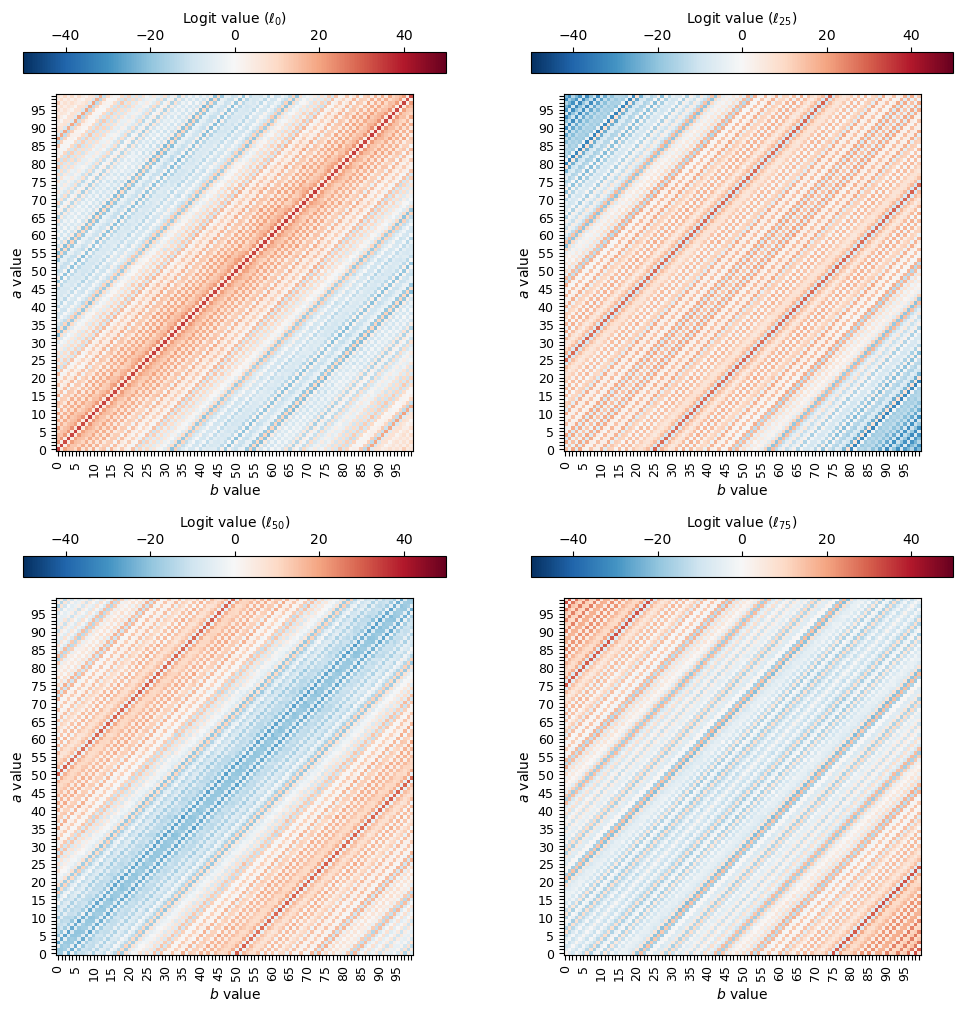

In [46]:
fig, axs = plt.subplots(2,2, figsize=(12,12))

all_axs = [axs[0][0], axs[0][1], axs[1][0], axs[1][1]]

for tokval, ax in zip([0, 25, 50, 75], all_axs):
    this_data = original_logits_sq.detach().numpy()[:,:,4]
    ft2d = np.fft.fft2(this_data)
    power = (ft2d*np.conj(ft2d)).real
    freqs = np.fft.fftfreq(100)
    
    this_token = tokenizer.get_vocab()[str(tokval)]
    plot = ax.imshow(this_data[:,:,this_token], cmap='RdBu_r', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(plot, fraction=0.1, location='top', orientation='horizontal')
    cbar.set_label(r'Logit value ($\ell_{{{}}}$)'.format(tokval))
    ax.set_ylim(-0.5, 99.5)
    ax.set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=9);
    ax.set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=9, rotation='vertical');
    ax.set_ylabel('$a$ value')
    ax.set_xlabel('$b$ value')
fig.savefig(figdir/'logit_values.png', dpi=300, bbox_inches='tight')

# What is W_logit doing?

In [47]:
print(neuron_acts_post.shape, W_logit.shape, original_logits.shape)
approx_logits = einops.einsum(neuron_acts_post, W_logit, "batch d_mlp, d_mlp d_vocab -> batch d_vocab")
approx_logits_sq = einops.rearrange(approx_logits, "(x y) d_vocab -> x y d_vocab", x=100)

torch.Size([10000, 512]) torch.Size([512, 103]) torch.Size([10000, 2, 102])


In [48]:
vmin = -50
vmax =  50

def plot_logit(token: int):
    clear_output()
    data = original_logits_sq.detach().numpy()[:,:,4]
    approx = approx_logits_sq.detach().numpy()[:,:]

    this_token = tokenizer.get_vocab()[str(token)]

    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    minmax = np.abs(data).max()
    plot = axs[0].imshow(data[:,:,this_token], cmap='RdBu_r', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(plot, fraction=0.1, location='top', orientation='horizontal')
    cbar.set_label(r'Logit value ($\ell_+$)')
    axs[0].set_ylim(-0.5, 99.5)
    axs[0].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[0].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
    axs[0].set_ylabel('$a$ value')
    axs[0].set_xlabel('$b$ value')
    
    plot = axs[1].imshow(approx[:,:,this_token], cmap='RdBu_r', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(plot, fraction=0.1, location='top', orientation='horizontal')
    cbar.set_label(r'Logit value ($\ell_+$)')
    axs[1].set_ylim(-0.5, 99.5)
    axs[1].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[1].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
    axs[1].set_ylabel('$a$ value')
    axs[1].set_xlabel('$b$ value')
    
interact(plot_logit, token=widgets.IntText(value=0, description='token:'))

interactive(children=(IntText(value=0, description='token:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_logit(token: int)>

Text(0, 0.5, 'd_vocab')

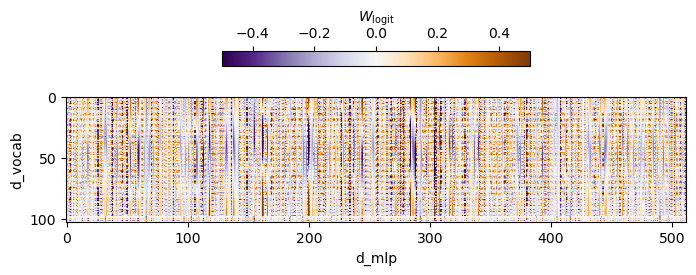

In [49]:
fig,ax = plt.subplots(1,1, figsize=(8, 8))
pic = ax.imshow(W_logit.T.detach().numpy(), cmap='PuOr_r', vmin=-0.5, vmax=0.5)
cbar = plt.colorbar(pic, orientation='horizontal', location='top', fraction=0.025)
cbar.set_label(r'$W_{\rm logit}$')
ax.set_xlabel('d_mlp')
ax.set_ylabel('d_vocab')
# axs[0].set_ylabel('vocab')
# axs[0].set_xlabel('vocab')
# axs[0].axhline(99.5, c='k')
# axs[0].axvline(99.5, c='k')
# axs[0].axhline(101.5, c='k')
# axs[0].axvline(101.5, c='k')
# axs[0].set_yticks(range(d_vocab));
# axs[0].set_xticks(range(d_vocab));
# axs[0].set_xticklabels(vocab, rotation='vertical', fontsize=4);
# axs[0].set_yticklabels(vocab, fontsize=4);


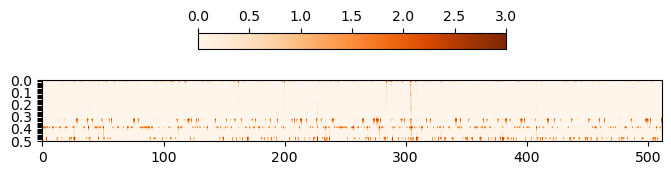

In [50]:
ft_wlogit = np.fft.rfft(W_logit.detach().numpy()[:,:100], axis=1)
freq = np.fft.rfftfreq(100)
power = (ft_wlogit*np.conj(ft_wlogit)).real

fig,ax = plt.subplots(1,1, figsize=(8, 8))
pic = ax.imshow(np.log10(power).T, cmap='Oranges', vmin=0, vmax=3)
cbar = plt.colorbar(pic, orientation='horizontal', location='top', fraction=0.025)
ax.set_yticks(range(freq.size))
ax.set_yticklabels(str(f) if (f*100) % 10 == 0 else '' for f in freq);


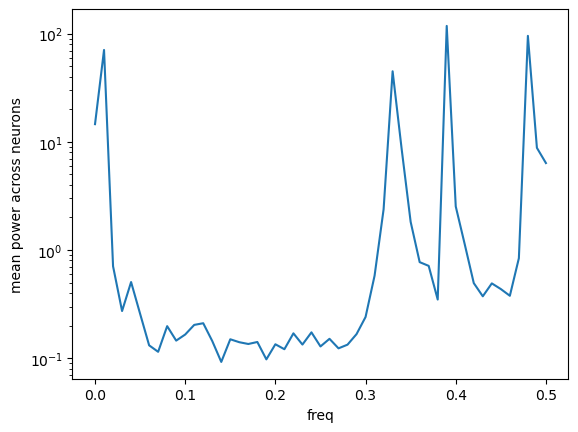

In [51]:
plt.plot(freq, power.mean(axis=0))
plt.xlabel('freq')
plt.ylabel('mean power across neurons')
plt.yscale('log')

In [52]:
def plot_neuron_Wlogit_pow(neuron: int):
    clear_output()

    fig,axs = plt.subplots(1,2, figsize=(8,4))
    axs[0].plot(range(100), W_logit[neuron,:100].detach().numpy())
    axs[0].set_xlabel('token value')
    axs[0].set_ylabel('W_logit value for neuron {}'.format(neuron))
    axs[1].plot(freq, power[neuron])
    axs[1].set_xlabel('freq')
    axs[1].set_ylabel('power in neuron {}'.format(neuron))
    axs[1].set_yscale('log')
    
interact(plot_neuron_Wlogit_pow, neuron=widgets.IntText(value=0, description='Index:'))

interactive(children=(IntText(value=0, description='Index:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_neuron_Wlogit_pow(neuron: int)>

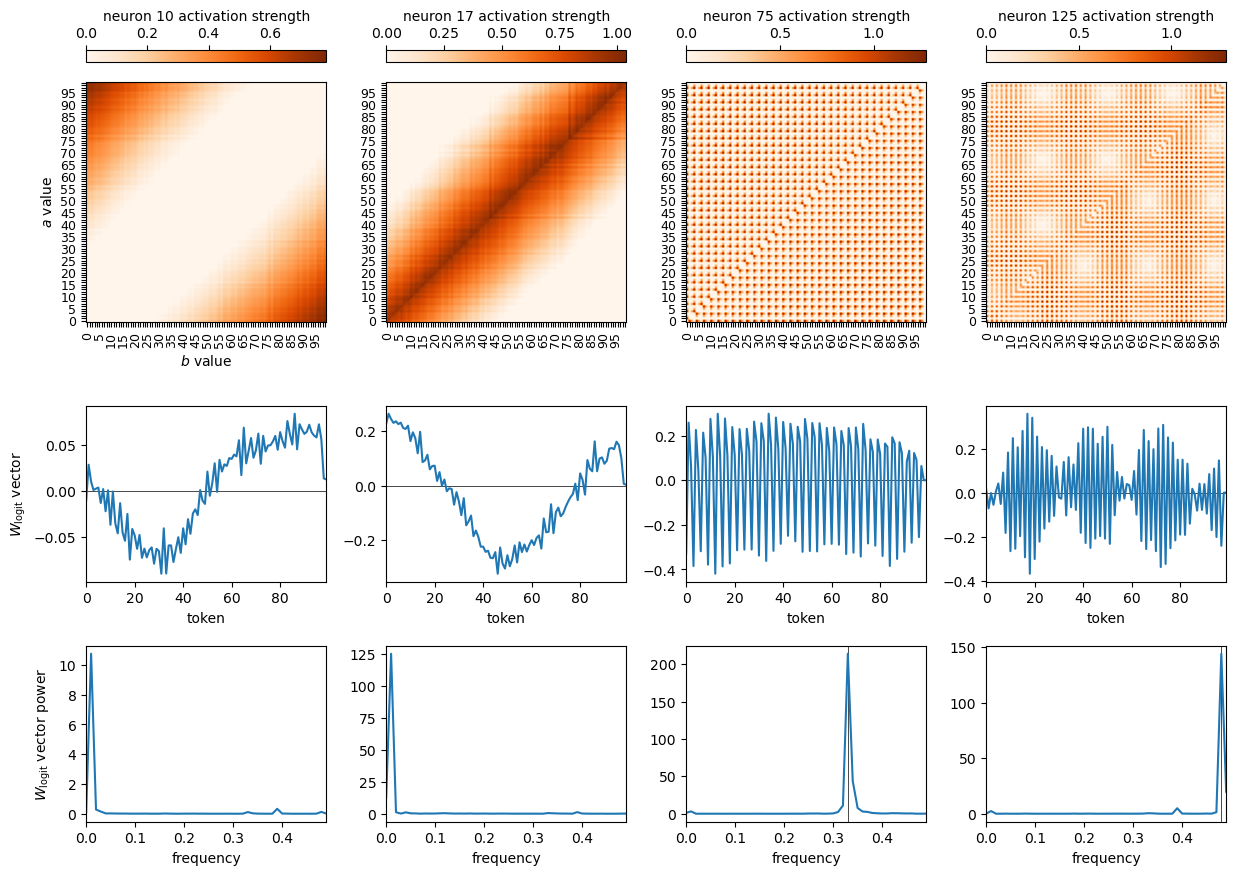

In [53]:
#plot sample neurons

fig = plt.figure(figsize=(12,8))
axs = [fig.add_axes([i*0.25, 0.5, 0.2, 0.5]) for i in range(4)]

neurons = [10, 17, 75, 125]
for i, n in enumerate(neurons):
    neur = neuron_acts_post_sq.detach().numpy()[:,:,n]
    minmax = np.abs(neur).max()
    plot = axs[i].imshow(neur, cmap='Oranges', vmin=0, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} activation strength'.format(n))
    axs[i].set_ylim(-0.5, 99.5)
    axs[i].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=9);
    axs[i].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=9, rotation='vertical');
    axs[0].set_xlabel(r'$b$ value')
axs[0].set_ylabel(r'$a$ value')

#W_logit

axs1 = [fig.add_axes([i*0.25, 0.3, 0.2, 0.22]) for i in range(4)]
axs2 = [fig.add_axes([i*0.25, 0, 0.2,  0.22]) for i in range(4)]

for ax1, ax2, n in zip(axs1, axs2, neurons):
    vector = W_logit.detach().numpy()
    
    ax1.axhline(0, c='k', lw=0.5)
    ax1.plot(vector[n,:100])
    ax1.set_xlabel('token')
    ax1.set_xlim(0,99)

    
    if n > 20:
        ax2.axvline(dominant_freq[n], c='k', lw=0.5)
    ft = np.fft.rfft(vector[n,:100])
    power = (ft*np.conj(ft)).real
    ax2.plot(np.fft.rfftfreq(100), power)
    ax2.set_xlabel('frequency')
    ax2.set_xlim(0,0.49)
axs1[0].set_ylabel(r'$W_{\rm logit}$ vector')
axs2[0].set_ylabel(r'$W_{\rm logit}$ vector power')

fig.savefig(figdir/'sample_neurons_w_logit.png', dpi=300, bbox_inches='tight')

W_logit seems to be picking out the key frequencies and also f = 0.01, which kinda fits with the function I used for W_neur...

# Neuron Activations -- this is where I figured stuff out.

In [54]:
attn_mat = cache['pattern', 0, 'attn'][:,:,-2,:]
neuron_acts_pre = cache['blocks.0.mlp.hook_pre'][:,-2]
neuron_acts_post = cache['blocks.0.mlp.hook_post'][:,-2]
print(neuron_acts_post.shape)
neuron_acts_post_sq = einops.rearrange(neuron_acts_post, "(x y) d_mlp -> x y d_mlp", x=100)
neuron_acts_pre_sq = einops.rearrange(neuron_acts_pre, "(x y) d_mlp -> x y d_mlp", x=100)

torch.Size([10000, 512])


In [55]:
def plot_neuronact(pos: int):
    clear_output()
    data = neuron_acts_post_sq.detach().numpy()[:,:,pos]
    ft2d = np.fft.fft2(data)
    power = (ft2d*np.conj(ft2d)).real
    freqs = np.fft.fftfreq(100)

    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    minmax = np.abs(data).max()
    plot = axs[0].imshow(data, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} activation strength'.format(pos))
    axs[0].set_ylim(-0.5, 99.5)
    axs[0].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[0].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
    axs[0].set_xlabel(r'$b$ value')
    axs[0].set_ylabel(r'$a$ value')
    
    plot = axs[1].imshow(np.log10(power), cmap='magma', vmin=0)#, vmax=1)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} log10 power'.format(pos))
    axs[1].set_ylim(-0.5, 99.5)
    axs[1].set_yticks(range(100));
    axs[1].set_yticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10);
    axs[1].set_xticks(range(100));
    axs[1].set_xticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10, rotation='vertical');
    axs[1].set_xlabel(r'$b$ frequency')
    axs[1].set_ylabel(r'$a$ frequency')
    
interact(plot_neuronact, pos=widgets.IntText(value=0, description='Index:'))

interactive(children=(IntText(value=0, description='Index:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_neuronact(pos: int)>

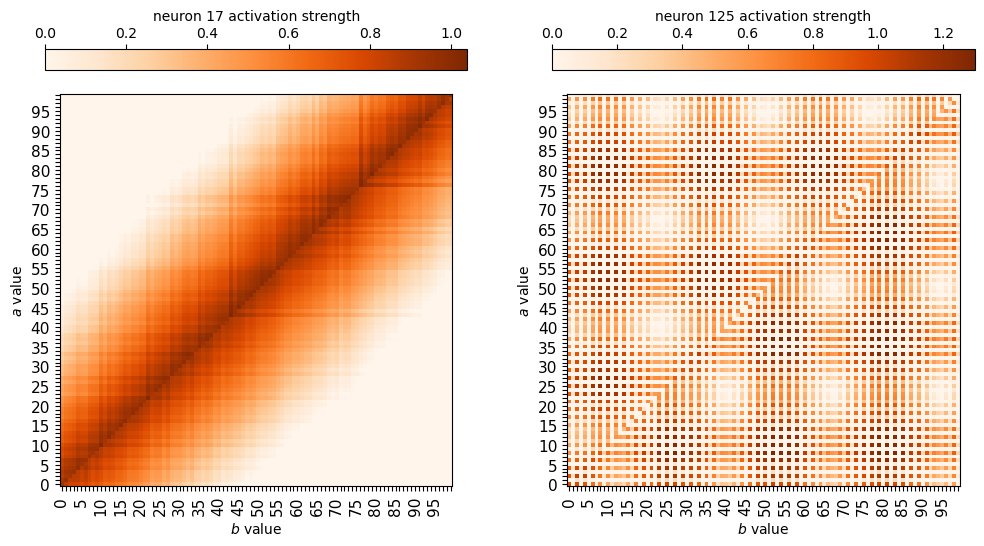

In [56]:
#plot sample neurons

fig, axs = plt.subplots(1, 2, figsize=(12,6))

neurons = [17, 125] #plus 10, 75 
for i, n in enumerate(neurons):
    neur = neuron_acts_post_sq.detach().numpy()[:,:,n]
    minmax = np.abs(neur).max()
    plot = axs[i].imshow(neur, cmap='Oranges', vmin=0, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} activation strength'.format(n))
    axs[i].set_ylim(-0.5, 99.5)
    axs[i].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[i].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
    axs[i].set_xlabel(r'$b$ value')
    axs[i].set_ylabel(r'$a$ value')

fig.savefig(figdir/'sample_neurons.png', dpi=300)

### Fit a simple linear trend to each neuron

Many neurons demonstrate a linear gradient from where $a >> b$ to where $b >> a$. Probably in terms of $a-$ and $b-$ space, this can be described in terms of a linear function $P(a,b) = c_1 (a-b) + c_3)$. Let's fit that function to each neuron and look at the fits.

In [57]:
def linfit(ab, c1, c2, c3, c4):
    a, b = ab
    result = a - b
    result[a >= b] *= c1
    result[a >= b] += c3
    result[a < b] *= c2
    result[a < b] += c4
    return result.ravel()

#start with neuron 17 -- it's a nice example.
neuron_17 =  neuron_acts_pre_sq.detach().numpy()[:,:,17]
avals = np.arange(100, dtype=float)
bvals = np.arange(100, dtype=float)
bb, aa = np.meshgrid(bvals, avals)



guess = (1., 1., 0,0)
popt, pcov = curve_fit(linfit, (aa,bb), neuron_17.ravel())#, p0=guess)
print(popt, pcov)

[-0.02080657  0.02005676  0.98214393  0.93273876] [[ 3.42954283e-10  2.70244150e-26 -1.13174913e-08  1.35122075e-24]
 [ 2.70244150e-26  3.56952413e-10 -1.35122074e-24  1.20173979e-08]
 [-1.13174913e-08 -1.35122074e-24  5.65874559e-07 -6.75610370e-23]
 [ 1.35122075e-24  1.20173979e-08 -6.75610370e-23  6.00869895e-07]]


In [58]:
k = 40
def plot_neuronact_fit(pos: int):
    clear_output()
    data = neuron_acts_pre_sq.detach().numpy()[:,:,pos]
    data_post = neuron_acts_post_sq.detach().numpy()[:,:,pos]

    guess = (1., 1, 0.,0)
    popt, pcov = curve_fit(linfit, (aa,bb), data.ravel())

    fig, axs = plt.subplots(2, 2, figsize=(12,12))
    minmax = np.abs(data).max()
    plot = axs[0][0].imshow(data, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} activation strength'.format(pos))
    axs[0][0].set_ylim(-0.5, 99.5)
    axs[0][0].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[0][0].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
    
    plot = axs[0][1].imshow(data - linfit((aa,bb), *popt).reshape(100,100), cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron - fit'.format(*popt))

    ft2d = np.fft.fft2(data)
    power = (ft2d*np.conj(ft2d)).real
    freqs = np.fft.fftfreq(100)
    plot = axs[1][0].imshow(np.log10(power), cmap='magma', vmin=3, vmax=6)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron pre {} log10 power'.format(pos))
    
    pre = t.topk(t.Tensor(power).ravel(), k=k)
    pre_indices = np.unravel_index(pre.indices.detach().numpy(), (100,100))
    pre_freqs = [[freqs[ind] for ind in indices] for indices in pre_indices]
    print('pow_explained:', power[pre_indices].sum()/power.sum())
    print(['{:+.02f}'.format(d) for d in pre_freqs[0]])
    print(['{:+.02f}'.format(d) for d in pre_freqs[1]])
    

    fit = linfit((aa,bb), *popt)
    fit[fit < 0] = 0
    ft2d = np.fft.fft2(data_post)
    power = (ft2d*np.conj(ft2d)).real
    freqs = np.fft.fftfreq(100)
    plot = axs[1][1].imshow(np.log10(power), cmap='magma', vmin=3, vmax=6)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron post {} log10 power'.format(pos))
    
    post = t.topk(t.Tensor(power).ravel(), k=k)
    post_indices = np.unravel_index(post.indices.detach().numpy(), (100,100))
    post_freqs = [[freqs[ind] for ind in indices] for indices in post_indices]
    print('pow_explained:', power[post_indices].sum()/power.sum())
    print(['{:+.02f}'.format(d) for d in post_freqs[0]])
    print(['{:+.02f}'.format(d) for d in post_freqs[1]])

    

    for ax in axs[0]:
        ax.set_ylim(-0.5, 99.5)
        ax.set_yticks(range(100));
        ax.set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
        ax.set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
        ax.set_xlabel(r'$b$ value')
        ax.set_ylabel(r'$a$ value')
    for ax in axs[1]:
        ax.set_ylim(-0.5, 99.5)
        ax.set_yticks(range(100));
        ax.set_yticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10);
        ax.set_xticks(range(100));
        ax.set_xticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10, rotation='vertical');
        ax.set_xlabel(r'$b$ frequency')
        ax.set_ylabel(r'$a$ frequency')
    
interact(plot_neuronact_fit, pos=widgets.IntText(value=76, description='Index:'))

interactive(children=(IntText(value=76, description='Index:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_neuronact_fit(pos: int)>

Neurons to look at and understand:
* Neuron 1 - onefreq
* Neuron 5 - onefreq
* Neuron 17 - linear
* Neuron 76 - takes about 100 freqs (only 1%!) -- constants and 'broad' peaks.
* Neuron 125 - beats (high frequencies)

### Look at neurons that are mostly just a strong linear feature

In [59]:
linear_neurons = []
fits = np.zeros((neuron_acts_pre_sq.shape[-1],4))
for i in range(tfm.cfg.d_mlp):
    guess = (0.1, 0.1, 0., 0.)
    this_data = neuron_acts_pre_sq.detach().numpy()[:,:,i]
    popt, pcov = curve_fit(linfit, (aa,bb), this_data.ravel())
    fit = linfit((aa,bb), *popt).reshape((100,100))
    fit[fit < 0] = 0

    post_data = neuron_acts_post_sq.detach().numpy()[:,:,i]
    power = (post_data**2).sum()
    nonlin_pow = ((post_data - fit)**2).sum()
    fits[i,:] = popt
    if (1 - nonlin_pow/power) >= 0.9:
        linear_neurons.append(i)
print(linear_neurons)

[7, 10, 17, 31, 32, 33, 40, 42, 52, 53, 59, 60, 61, 64, 68, 69, 72, 77, 78, 94, 95, 98, 101, 105, 107, 108, 113, 117, 118, 119, 131, 132, 135, 138, 139, 141, 142, 155, 158, 161, 162, 166, 172, 177, 180, 190, 196, 198, 200, 202, 203, 205, 207, 215, 217, 222, 228, 229, 238, 242, 244, 253, 254, 259, 272, 284, 286, 287, 288, 293, 297, 298, 304, 308, 315, 316, 319, 321, 325, 330, 334, 337, 340, 348, 356, 360, 372, 375, 377, 379, 393, 403, 406, 412, 426, 429, 431, 432, 433, 440, 444, 445, 446, 452, 455, 459, 463, 465, 468, 474, 475, 477, 484, 485, 488, 493, 503, 509]


In [60]:
def plot_linear_fit_neurons(pos: int):
    clear_output()
    pos = linear_neurons[pos]
    data = neuron_acts_post_sq.detach().numpy()[:,:,pos]

    guess = (1., 1, 0.,0)
    popt, pcov = curve_fit(linfit, (aa,bb), data.ravel())

    fig, axs = plt.subplots(2, 2, figsize=(12,12))
    minmax = np.abs(data).max()
    plot = axs[0][0].imshow(data, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} activation strength'.format(pos))
    axs[0][0].set_ylim(-0.5, 99.5)
    axs[0][0].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[0][0].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');

    ft2d = np.fft.fft2(data)
    power = (ft2d*np.conj(ft2d)).real
    freqs = np.fft.fftfreq(100)
    plot = axs[1][0].imshow(np.log10(power), cmap='magma', vmin=np.log10(power).max()-4, vmax=np.log10(power).max())
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} log10 power'.format(pos))

    new_data = fit = linfit((aa,bb), *tuple(fits[pos,:])).reshape((100,100))
    new_data[new_data < 0] = 0
    new_ft2d = np.fft.fft2(new_data)
    new_power = (new_ft2d*np.conj(new_ft2d)).real

    nonlin_pow = ((data - new_data)**2).sum()
    power = (data**2).sum()
    print('power explained by fit: {}'.format((1 - nonlin_pow/power)))
    
    plot = axs[0][1].imshow(new_data.real, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} topk activation strength'.format(pos))

    plot = axs[1][1].imshow(np.log10(new_power), cmap='magma', vmin=np.log10(new_power).max()-4, vmax=np.log10(new_power).max())
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} topk log10 power'.format(pos))

    for ax in axs[0]:
        ax.set_ylim(-0.5, 99.5)
        ax.set_yticks(range(100));
        ax.set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
        ax.set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
        ax.set_xlabel(r'$b$ value')
        ax.set_ylabel(r'$a$ value')
    for ax in axs[1]:
        ax.set_ylim(-0.5, 99.5)
        ax.set_yticks(range(100));
        ax.set_yticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10);
        ax.set_xticks(range(100));
        ax.set_xticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10, rotation='vertical');
        ax.set_xlabel(r'$b$ frequency')
        ax.set_ylabel(r'$a$ frequency')

    plt.figure()
    plt.plot(W_logit[pos,:100].detach().numpy())
    
interact(plot_linear_fit_neurons, pos=widgets.IntText(value=0, description='Index:'))

interactive(children=(IntText(value=0, description='Index:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_linear_fit_neurons(pos: int)>

In [61]:
# replace all neurons with simple fit
def remove_linfit_neurons(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    for ind in linear_neurons:
        neurons[:,4,ind] = t.Tensor(linfit((aa,bb), fits[ind,0], fits[ind,1], fits[ind,2], fits[ind,3]))

ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), remove_linfit_neurons)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('replacing neurons')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

replacing neurons
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06826339 0.01766803], Ablated acc: [98.549995 99.94    ]%


So there are two classes of neurons here. One class which boosts 0 as an answer, and another class which boosts 99 as an answer (with some linear change between).

### Look at neurons where you just keep one freq in fourier space.

In [62]:
print(key_freqs)
onefreq_neurons = []
onefreq_freqs = []
for i in range(tfm.cfg.d_mlp):
    
    thisdata = neuron_acts_post_sq.detach().numpy()[:,:,i]
    freqs = np.fft.fftfreq(100)
    ft2d = np.fft.fft2(thisdata)
    power = (ft2d*np.conj(ft2d)).real
    for freq in key_freqs:
        indices = np.where(np.abs(freqs) == freq)
        mask = np.zeros_like(power, dtype=bool)
        mask[indices,:] = True
        mask[:,indices] = True
        mask[0,0] = True
        if power[mask].sum()/power.sum() >= 0.9 and i not in linear_neurons:
            onefreq_neurons.append(i)
            onefreq_freqs.append(freq)
print(onefreq_neurons)
print(onefreq_freqs)
print(len(linear_neurons), len(onefreq_neurons))

[0.33, 0.39, 0.48]
[1, 3, 5, 12, 19, 35, 38, 47, 67, 70, 80, 88, 99, 104, 114, 115, 126, 128, 130, 134, 136, 145, 151, 157, 167, 175, 183, 193, 197, 199, 233, 237, 243, 245, 257, 269, 289, 294, 305, 318, 322, 333, 359, 368, 369, 370, 397, 399, 400, 413, 422, 438, 450, 467, 470, 473, 476, 478, 489, 494, 506, 507, 508]
[0.39, 0.48, 0.39, 0.48, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.48, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.48, 0.39, 0.39, 0.48, 0.48, 0.39, 0.39, 0.48, 0.48, 0.39, 0.39, 0.39, 0.48, 0.48, 0.48, 0.39, 0.39, 0.48, 0.48, 0.39, 0.48, 0.39, 0.39, 0.39, 0.48, 0.39, 0.48, 0.48, 0.48, 0.48, 0.39, 0.48, 0.39, 0.48, 0.48, 0.48, 0.39, 0.48, 0.39, 0.48]
118 63


In [63]:
def plot_neuronact_fit(neuron: int):
    clear_output()
    pos = onefreq_neurons[neuron]
    data = neuron_acts_post_sq.detach().numpy()[:,:,pos]

    guess = (1., 1, 0.,0)
    popt, pcov = curve_fit(linfit, (aa,bb), data.ravel())

    fig, axs = plt.subplots(2, 2, figsize=(12,12))
    minmax = np.abs(data).max()
    plot = axs[0][0].imshow(data, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} activation strength'.format(pos))
    axs[0][0].set_ylim(-0.5, 99.5)
    axs[0][0].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[0][0].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');

    ft2d = np.fft.fft2(data)
    power = (ft2d*np.conj(ft2d)).real
    freqs = np.fft.fftfreq(100)
    plot = axs[1][0].imshow(np.log10(power), cmap='magma', vmin=np.log10(power).max()-4, vmax=np.log10(power).max())
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} log10 power'.format(pos))

    indices = np.where(np.abs(freqs) == onefreq_freqs[neuron])
    mask = np.zeros_like(power, dtype=bool)
    mask[indices,:] = True
    mask[:,indices] = True
    mask[0,0] = True
    
    print('pow_explained:', power[mask].sum()/power.sum())

    new_ft2d = np.ones_like(ft2d)*1e-16
    new_ft2d[mask] = ft2d[mask]
    new_power = (new_ft2d*np.conj(new_ft2d)).real

    new_data = np.fft.ifft2(new_ft2d)
    
    plot = axs[0][1].imshow(new_data.real, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} topk activation strength'.format(pos))

    plot = axs[1][1].imshow(np.log10(new_power), cmap='magma', vmin=np.log10(new_power).max()-4, vmax=np.log10(new_power).max())
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} topk log10 power'.format(pos))

    for ax in axs[0]:
        ax.set_ylim(-0.5, 99.5)
        ax.set_yticks(range(100));
        ax.set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
        ax.set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
        ax.set_xlabel(r'$b$ value')
        ax.set_ylabel(r'$a$ value')
    for ax in axs[1]:
        ax.set_ylim(-0.5, 99.5)
        ax.set_yticks(range(100));
        ax.set_yticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10);
        ax.set_xticks(range(100));
        ax.set_xticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10, rotation='vertical');
        ax.set_xlabel(r'$b$ frequency')
        ax.set_ylabel(r'$a$ frequency')

    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    axs[0].plot(W_logit[pos,:100].detach().numpy())
    ft = np.fft.rfft(W_logit[pos,:100].detach().numpy())
    axs[1].plot(np.fft.rfftfreq(100), (ft*np.conj(ft)).real)
    
interact(plot_neuronact_fit, neuron=widgets.IntText(value=0, description='Index:'))

interactive(children=(IntText(value=0, description='Index:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_neuronact_fit(neuron: int)>

So them unembedding of these neurons seems to primarily involve a multiplication of e.g., cos(c). Tests:

* ablate non-key freqs of W_logit (first test neur * W_logit = logit)
* Ablate non-cross freqs in FT (is it using those in the logit calculation?)
* Ablate all but 9 key pieces.

Thought: it seems like the f = 0.39 is really its own class. There's a separate class of f = 0.48 that sometimes creeps in here (beats).

In [64]:
# replace all neurons with simple fit
def remove_sinfit_neurons(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    for ind, freq in zip(onefreq_neurons, onefreq_freqs):
        
        neuron_act = einops.rearrange(neurons[:,4,ind].detach().numpy(), "(x y) -> x y", x=100)
        ft2d = np.fft.fft2(neuron_act)
        power = ft2d*np.conj(ft2d)

        #Just keep the dominant frequency. And honestly not even the cross terms.
        indices = np.where(np.abs(freqs) == freq)
        mask = np.zeros_like(power, dtype=bool)
        for indx1 in indices:
            # for indx2 in indices:
            #     mask[indx1, indx2] = True
            mask[indx1,0] = True
            mask[0,indx1] = True
        mask[0,0] = True
        
        new_ft2d = np.ones_like(ft2d)*1e-16
        new_ft2d[mask] = ft2d[mask]
        neurons[:,4,ind] = t.Tensor(np.fft.ifft2(new_ft2d).ravel())

ablate_freqs = functools.partial(remove_sinfit_neurons)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_post"), remove_sinfit_neurons),
                (utils.get_act_name("blocks.0.mlp.hook_pre"), remove_linfit_neurons)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('replacing neurons')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

replacing neurons
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06826339 0.02006658], Ablated acc: [98.549995 99.94    ]%


/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_74560/2543108480.py:24: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699325338999/work/aten/src/ATen/native/Copy.cpp:299.)
  neurons[:,4,ind] = t.Tensor(np.fft.ifft2(new_ft2d).ravel())


In [65]:
# replace all neurons with simple fit
def remove_other_neurons(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    for i in range(tfm.cfg.d_mlp):
        if (i not in onefreq_neurons) and (i not in linear_neurons):
            neurons[:,4,i] = 0
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_post"), remove_other_neurons),
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('removing others')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

removing others
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [ 0.06826339 11.331222  ], Ablated acc: [98.549995   1.4399999]%


### Look at neurons with beats

Try keeping constant freqs ~ 0.42 -> -0.42, and cross-freqs 0.46 -> -0.46

In [66]:
bandfreq_neurons = []
for i in range(tfm.cfg.d_mlp):
    thisdata = neuron_acts_post_sq.detach().numpy()[:,:,i]
    freqs = np.fft.fftfreq(100)
    ft2d = np.fft.fft2(thisdata)
    indices_a = [0]
    indices_b = [0]
    for ind in range(np.where(freqs == 0.42)[0][0], np.where(freqs == -0.42)[0][0]):
        indices_a.append(ind)
        indices_b.append(0)
        
        indices_a.append(0)
        indices_b.append(ind)
    for ind in range(np.where(freqs == 0.46)[0][0], np.where(freqs == -0.46)[0][0]):
        for ind2 in range(np.where(freqs == 0.46)[0][0], np.where(freqs == -0.46)[0][0]):
            indices_a.append(ind)
            indices_b.append(ind2)
    
    power = (ft2d*np.conj(ft2d)).real
    indices = (np.array(indices_a,dtype=int), np.array(indices_b, dtype=int))
    # print(power[indices].sum()/power.sum())
    if power[indices].sum()/power.sum() >= 0.9 and i not in linear_neurons and i not in onefreq_neurons:
        bandfreq_neurons.append(i)
print(bandfreq_neurons)
print(len(linear_neurons), len(onefreq_neurons), len(bandfreq_neurons))

[30, 36, 46, 56, 102, 146, 225, 231, 258, 262, 282, 302, 338, 449, 495, 496]
118 63 16


In [67]:
def plot_neuronact_fit(pos: int):
    clear_output()
    pos = bandfreq_neurons[pos]
    data = neuron_acts_post_sq.detach().numpy()[:,:,pos]

    guess = (1., 1, 0.,0)
    popt, pcov = curve_fit(linfit, (aa,bb), data.ravel())

    fig, axs = plt.subplots(2, 2, figsize=(12,12))
    minmax = np.abs(data).max()
    plot = axs[0][0].imshow(data, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} activation strength'.format(pos))
    axs[0][0].set_ylim(-0.5, 99.5)
    axs[0][0].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[0][0].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');

    ft2d = np.fft.fft2(data)
    power = (ft2d*np.conj(ft2d)).real
    freqs = np.fft.fftfreq(100)
    plot = axs[1][0].imshow(np.log10(power), cmap='magma', vmin=np.log10(power).max()-4, vmax=np.log10(power).max())
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} log10 power'.format(pos))

    indices_a = [0]
    indices_b = [0]
    for ind in range(np.where(freqs == 0.42)[0][0], np.where(freqs == -0.42)[0][0]):
        indices_a.append(ind)
        indices_b.append(0)
        
        indices_a.append(0)
        indices_b.append(ind)

    # print(freqs == 0.47)
    for ind in range(np.where(freqs == 0.46)[0][0], np.where(freqs == -0.46)[0][0]):
        for ind2 in range(np.where(freqs == 0.46)[0][0], np.where(freqs == -0.46)[0][0]):
            indices_a.append(ind)
            indices_b.append(ind2)
    
    indices = (np.array(indices_a,dtype=int), np.array(indices_b, dtype=int))
    # print(indices, power[indices].shape)
    
    pre_freqs = [[freqs[ind] for ind in indx] for indx in indices]
    print('pow_explained:', power[indices].sum()/power.sum())

    new_ft2d = np.ones_like(ft2d)*1e-16
    new_ft2d[indices] = ft2d[indices]
    new_power = (new_ft2d*np.conj(new_ft2d)).real

    new_data = np.fft.ifft2(new_ft2d)
    
    plot = axs[0][1].imshow(new_data.real, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} topk activation strength'.format(pos))

    plot = axs[1][1].imshow(np.log10(new_power), cmap='magma', vmin=np.log10(new_power).max()-4, vmax=np.log10(new_power).max())
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} topk log10 power'.format(pos))

    for ax in axs[0]:
        ax.set_ylim(-0.5, 99.5)
        ax.set_yticks(range(100));
        ax.set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
        ax.set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
        ax.set_xlabel(r'$b$ value')
        ax.set_ylabel(r'$a$ value')
    for ax in axs[1]:
        ax.set_ylim(-0.5, 99.5)
        ax.set_yticks(range(100));
        ax.set_yticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10);
        ax.set_xticks(range(100));
        ax.set_xticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10, rotation='vertical');
        ax.set_xlabel(r'$b$ frequency')
        ax.set_ylabel(r'$a$ frequency')
    
interact(plot_neuronact_fit, pos=widgets.IntText(value=0, description='Index:'))

interactive(children=(IntText(value=0, description='Index:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_neuronact_fit(pos: int)>

### Look at neurons where you just keep many freqs in fourier space

In [68]:
k = 100
manyfreq_neurons = []
for i in range(tfm.cfg.d_mlp):
    thisdata = neuron_acts_post_sq.detach().numpy()[:,:,i]
    ft2d = np.fft.fft2(thisdata)
    power = (ft2d*np.conj(ft2d)).real
    pre = t.topk(t.Tensor(power).ravel(), k=k)
    pre_indices = np.unravel_index(pre.indices.detach().numpy(), (100,100))
    if power[pre_indices].sum()/power.sum() >= 0.9 and i not in linear_neurons and i not in onefreq_neurons:# and i not in bandfreq_neurons:
        manyfreq_neurons.append(i)
print(manyfreq_neurons)
print(len(linear_neurons), len(onefreq_neurons), len(bandfreq_neurons), len(manyfreq_neurons))

[0, 2, 4, 6, 9, 11, 14, 15, 16, 20, 21, 22, 25, 28, 29, 30, 34, 36, 37, 39, 43, 44, 46, 49, 50, 51, 54, 55, 56, 57, 58, 62, 63, 74, 76, 79, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 96, 100, 102, 106, 110, 112, 121, 122, 124, 125, 144, 146, 147, 149, 152, 153, 156, 159, 160, 163, 164, 165, 168, 170, 171, 174, 178, 179, 182, 186, 187, 188, 189, 191, 192, 194, 204, 206, 209, 210, 211, 212, 213, 216, 218, 220, 221, 223, 224, 225, 227, 230, 231, 232, 234, 235, 236, 241, 247, 248, 249, 251, 252, 255, 256, 258, 260, 262, 263, 266, 267, 268, 271, 273, 274, 275, 276, 278, 280, 281, 282, 283, 285, 291, 296, 299, 300, 301, 302, 303, 306, 309, 310, 314, 317, 320, 323, 324, 326, 327, 328, 329, 331, 332, 335, 338, 339, 342, 343, 344, 346, 347, 350, 351, 353, 355, 357, 361, 362, 365, 366, 367, 371, 374, 376, 378, 380, 381, 382, 383, 384, 386, 387, 389, 390, 391, 392, 394, 396, 401, 402, 404, 408, 409, 410, 411, 414, 415, 418, 419, 423, 424, 425, 430, 434, 435, 436, 441, 443, 448, 449, 451, 453, 45

In [69]:
def plot_neuronact_fit(pos: int):
    clear_output()
    pos = manyfreq_neurons[pos]
    data = neuron_acts_post_sq.detach().numpy()[:,:,pos]

    fig, axs = plt.subplots(2, 2, figsize=(12,12))
    minmax = np.abs(data).max()
    plot = axs[0][0].imshow(data, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} activation strength'.format(pos))
    axs[0][0].set_ylim(-0.5, 99.5)
    axs[0][0].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[0][0].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');

    ft2d = np.fft.fft2(data)
    power = (ft2d*np.conj(ft2d)).real
    freqs = np.fft.fftfreq(100)
    plot = axs[1][0].imshow(np.log10(power), cmap='magma', vmin=np.log10(power).max()-4, vmax=np.log10(power).max())
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} log10 power'.format(pos))
    
    pre = t.topk(t.Tensor(power).ravel(), k=k)
    pre_indices = np.unravel_index(pre.indices.detach().numpy(), (100,100))
    pre_freqs = [[freqs[ind] for ind in indices] for indices in pre_indices]
    print('pow_explained:', power[pre_indices].sum()/power.sum())
    # print(['{:+.02f}'.format(d) for d in pre_freqs[0]])
    # print(['{:+.02f}'.format(d) for d in pre_freqs[1]])

    new_ft2d = np.ones_like(ft2d)*1e-16
    new_ft2d[pre_indices] = ft2d[pre_indices]
    new_power = (new_ft2d*np.conj(new_ft2d)).real

    # new_data = np.fft.ifft2(new_ft2d)
    new_data = t.clone(t.Tensor(data))[50:,:50]
    new_ft2d = np.fft.fft2(new_data)
    new_power = (new_ft2d*np.conj(new_ft2d)).real
    print(new_data.shape)
    # print(new_data.shape)
    # # new_data[t.tril(t.ones_like(new_data), diagonal=-1).to(bool)] = new_data[t.triu(t.ones_like(new_data), diagonal=1).to(bool).T] #this works
    # for i in range(100):
    #     for j in range(100):
    #         if i == j: break
    #         new_data[i,j] = new_data[-j+1,-i+1] #This is what the neuron is actually doing.
    #     if i == 50: break
    # new_data[t.tril(t.ones_like(new_data), diagonal=-1).to(bool)] = new_data[t.tril(t.ones_like(new_data), diagonal=-1).to(bool)]
    
    plot = axs[0][1].imshow(new_data.real, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} topk activation strength'.format(pos))

    plot = axs[1][1].imshow(np.log10(new_power), cmap='magma', vmin=np.log10(new_power).max()-4, vmax=np.log10(new_power).max())
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} topk log10 power'.format(pos))

    for ax in axs[0]:
        ax.set_ylim(-0.5, 99.5)
        ax.set_yticks(range(100));
        ax.set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
        ax.set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
        ax.set_xlabel(r'$b$ value')
        ax.set_ylabel(r'$a$ value')
        break
    for ax in axs[1]:
        ax.set_ylim(-0.5, 99.5)
        ax.set_yticks(range(100));
        ax.set_yticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10);
        ax.set_xticks(range(100));
        ax.set_xticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10, rotation='vertical');
        ax.set_xlabel(r'$b$ frequency')
        ax.set_ylabel(r'$a$ frequency')
        break

    ax = axs[0][1]
    ax.set_ylim(-0.5, 49.5)
    ax.set_yticks(range(50));
    ax.set_yticks(range(50), labels=[i if i % 5 == 0 else '' for i in range(50)], size=11);
    ax.set_xticks(range(50), labels=[i if i % 5 == 0 else '' for i in range(50)], size=11, rotation='vertical');
    
    freqs = np.fft.fftfreq(50)
    axs[1][1].set_ylim(-0.5, 49.5)
    axs[1][1].set_yticks(range(50))
    axs[1][1].set_yticklabels([f'{freq:.2f}' if (freq*100 % 10 == 0) else '' for freq in freqs], fontsize=10);


    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    axs[0].plot(W_logit[pos,:100].detach().numpy())
    ft = np.fft.rfft(W_logit[pos,:100].detach().numpy())
    axs[1].plot(np.fft.rfftfreq(100), (ft*np.conj(ft)).real)
    
interact(plot_neuronact_fit, pos=widgets.IntText(value=0, description='Index:'))

interactive(children=(IntText(value=0, description='Index:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_neuronact_fit(pos: int)>

These neurons all have a strong discontinuity on the diagonal. The upper triangular portion is the transpose of the lower triangular portion.

Procedure: fit sines and cosines for dominant frequency to the lower diagonal. Transpose to upper diagonal.

In [70]:
#pseudocode:
# loop over the neurons
# figure out how much power is in each key frequency f1
# store key frequency.
# define function for fitting const + amp1*cos(f1*a + p1) + amp2*cos(f1*b + p2) + amp3*cos(f1*a + p3)*cos(f1*b+p4)
# Fit function on lower triangle on pre-activation.
# see how much of neuron activation is reconstructed.

In [71]:
manyfreq_freqs = []
for i in manyfreq_neurons:
    
    this_data = neuron_acts_post_sq.detach().numpy()[:,:,i]
    freqs = np.fft.fftfreq(100)
    ft2d = np.fft.fft2(this_data)
    power = (ft2d*np.conj(ft2d)).real
    these_powfracs = []
    for freq in key_freqs:
        indices = np.where(np.abs(freqs) == freq)
        mask = np.zeros_like(power, dtype=bool)
        mask[indices,:] = True
        mask[:,indices] = True
        these_powfracs.append(power[mask].sum()/power.sum())
    manyfreq_freqs.append(key_freqs[np.argmax(these_powfracs)])
print(manyfreq_freqs)


[0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.48, 0.39, 0.39, 0.48, 0.39, 0.33, 0.33, 0.48, 0.39, 0.48, 0.33, 0.48, 0.39, 0.39, 0.48, 0.33, 0.39, 0.48, 0.48, 0.33, 0.48, 0.33, 0.39, 0.39, 0.39, 0.39, 0.33, 0.33, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.48, 0.39, 0.48, 0.48, 0.39, 0.39, 0.48, 0.48, 0.48, 0.39, 0.33, 0.48, 0.39, 0.48, 0.39, 0.48, 0.39, 0.48, 0.33, 0.39, 0.39, 0.33, 0.48, 0.48, 0.33, 0.48, 0.39, 0.48, 0.39, 0.39, 0.39, 0.39, 0.39, 0.48, 0.39, 0.33, 0.48, 0.48, 0.39, 0.33, 0.48, 0.33, 0.48, 0.33, 0.48, 0.39, 0.33, 0.48, 0.33, 0.48, 0.39, 0.39, 0.48, 0.48, 0.48, 0.33, 0.48, 0.39, 0.39, 0.48, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.48, 0.39, 0.39, 0.48, 0.39, 0.48, 0.39, 0.39, 0.48, 0.39, 0.48, 0.33, 0.33, 0.48, 0.33, 0.39, 0.39, 0.39, 0.48, 0.48, 0.48, 0.39, 0.33, 0.33, 0.48, 0.39, 0.48, 0.39, 0.48, 0.48, 0.48, 0.39, 0.33, 0.33, 0.39, 0.48, 0.39, 0.48, 0.39, 0.48, 0.39, 0.48, 0.39, 0.48, 0.48, 0.33, 0.39, 0.39, 0.39, 0.48, 0.48, 0.48, 0.39, 0.48, 0.39, 0.48, 0.48, 0.3

In [72]:
manyfreq_popts = []
for i, f1 in zip(manyfreq_neurons, manyfreq_freqs):
    def fit_one_freq(data, const, amp1, amp2, amp3, p1, p2, p3, p4):
        a, b = data
        om = 2*np.pi*f1
        return const + amp1*np.cos(om*a + p1) + amp2*np.cos(om*b + p2) + amp3*np.cos(om*a + p3)*np.cos(om*b + p4)
    preactivation = neuron_acts_pre_sq.detach().numpy()[:,:,i]
    #get upper left corner where a >= b a goes 50-99, b goes 0-49
    good_square = preactivation[50:,:50]
    avals = aa[50:, :50]
    bvals = bb[50:, :50]
    popt, pcov = curve_fit(fit_one_freq, (avals.ravel(), bvals.ravel()), good_square.ravel())
    manyfreq_popts.append(popt)
    

In [73]:
def plot_neuronact_fit(pos: int):
    clear_output()
    f1,pos,popt = manyfreq_freqs[pos], manyfreq_neurons[pos], manyfreq_popts[pos]
    print(popt)
    def fit_one_freq(data, const, amp1, amp2, amp3, p1, p2, p3, p4):
        a, b = data
        om = 2*np.pi*f1
        return const + amp1*np.cos(om*a + p1) + amp2*np.cos(om*b + p2) + amp3*np.cos(om*a + p3)*np.cos(om*b + p4)
    data = neuron_acts_post_sq.detach().numpy()[:,:,pos]

    fig, axs = plt.subplots(2, 2, figsize=(12,12))
    minmax = np.abs(data).max()
    plot = axs[0][0].imshow(data, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} activation strength'.format(pos))
    axs[0][0].set_ylim(-0.5, 99.5)
    axs[0][0].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[0][0].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');

    ft2d = np.fft.fft2(data)
    power = (ft2d*np.conj(ft2d)).real
    freqs = np.fft.fftfreq(100)
    plot = axs[1][0].imshow(np.log10(power), cmap='magma', vmin=np.log10(power).max()-4, vmax=np.log10(power).max())
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} log10 power'.format(pos))

    # new_data = np.fft.ifft2(new_ft2d)
    new_data = t.Tensor(fit_one_freq((aa,bb), *popt))
    new_data[new_data < 0] = 0
    for i in range(100):
        for j in range(100):
            if j > i:  #if b > a -> set answer to same thing where a > b
                new_data[i,j] = new_data[j,i] #This is what the neuron is actually doing.
    # new_data[t.triu(t.ones_like(new_data), diagonal=1).to(bool)] = new_data[t.tril(t.ones_like(new_data), diagonal=0).to(bool).T] #this works
    # new_data[t.tril(t.ones_like(new_data), diagonal=-1).to(bool)] = new_data[t.triu(t.ones_like(new_data), diagonal=1).to(bool).T] #this works
    new_ft2d = np.fft.fft2(new_data)
    new_power = (new_ft2d*np.conj(new_ft2d)).real
    
    print('variance_explained:', 1 - ((data - new_data.numpy())**2).sum()/(data**2).sum())
    
    plot = axs[0][1].imshow(new_data.real, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} topk activation strength'.format(pos))
    # axs[0][1].plot(np.arange(100), np.arange(100))

    plot = axs[1][1].imshow(np.log10(new_power), cmap='magma', vmin=np.log10(new_power).max()-4, vmax=np.log10(new_power).max())
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} topk log10 power'.format(pos))

    for ax in axs[0]:
        ax.set_ylim(-0.5, 99.5)
        ax.set_yticks(range(100));
        ax.set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
        ax.set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
        ax.set_xlabel(r'$b$ value')
        ax.set_ylabel(r'$a$ value')
    for ax in axs[1]:
        ax.set_ylim(-0.5, 99.5)
        ax.set_yticks(range(100));
        ax.set_yticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10);
        ax.set_xticks(range(100));
        ax.set_xticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10, rotation='vertical');
        ax.set_xlabel(r'$b$ frequency')
        ax.set_ylabel(r'$a$ frequency')

    # ax = axs[0][1]
    # ax.set_ylim(-0.5, 49.5)
    # ax.set_yticks(range(50));
    # ax.set_yticks(range(50), labels=[i if i % 5 == 0 else '' for i in range(50)], size=11);
    # ax.set_xticks(range(50), labels=[i if i % 5 == 0 else '' for i in range(50)], size=11, rotation='vertical');
    
    # freqs = np.fft.fftfreq(50)
    # axs[1][1].set_ylim(-0.5, 49.5)
    # axs[1][1].set_yticks(range(50))
    # axs[1][1].set_yticklabels([f'{freq:.2f}' if (freq*100 % 10 == 0) else '' for freq in freqs], fontsize=10);


    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    axs[0].plot(W_logit[pos,:100].detach().numpy())
    ft = np.fft.rfft(W_logit[pos,:100].detach().numpy())
    axs[1].plot(np.fft.rfftfreq(100), (ft*np.conj(ft)).real)
    
interact(plot_neuronact_fit, pos=widgets.IntText(value=1, description='Index:'))

interactive(children=(IntText(value=1, description='Index:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_neuronact_fit(pos: int)>

In [74]:
# replace all neurons with simple fit
def replace_choppedfit_neurons(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:

    for f1,ind,popt in zip(manyfreq_freqs, manyfreq_neurons, manyfreq_popts):
        def fit_one_freq(data, const, amp1, amp2, amp3, p1, p2, p3, p4):
            a, b = data
            om = 2*np.pi*f1
            return const + amp1*np.cos(om*a + p1) + amp2*np.cos(om*b + p2) + amp3*np.cos(om*a + p3)*np.cos(om*b + p4)
        
   
        new_data = t.Tensor(fit_one_freq((aa,bb), *popt))
        new_data[new_data < 0] = 0
        for i in range(100):
            for j in range(100):
                if j > i:  #if b > a -> set answer to same thing where a > b
                    new_data[i,j] = new_data[j,i] #This is what the neuron is actually doing.
        
        neurons[:,4,ind] = new_data.ravel()

ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_post"), replace_choppedfit_neurons),
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('replacing neurons')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

replacing neurons
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06826339 0.01845948], Ablated acc: [98.549995 99.94    ]%


In [75]:
# replace all neurons with simple fit
def remove_other_neurons(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    for i in range(tfm.cfg.d_mlp):
        if (i not in onefreq_neurons) and (i not in linear_neurons) and (i not in manyfreq_neurons):
            neurons[:,4,i] = 0
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_post"), remove_other_neurons),
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('removing others')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

removing others
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06826339 0.20729558], Ablated acc: [98.549995 94.03    ]%


## What's left?

In [76]:
remaining_neurons = []
for i in range(tfm.cfg.d_mlp):
    if (i not in onefreq_neurons) and (i not in linear_neurons) and (i not in manyfreq_neurons):
        remaining_neurons.append(i)
print(remaining_neurons)

[8, 13, 18, 23, 24, 26, 27, 41, 45, 48, 65, 66, 71, 73, 75, 90, 97, 103, 109, 111, 116, 120, 123, 127, 129, 133, 137, 140, 143, 148, 150, 154, 169, 173, 176, 181, 184, 185, 195, 201, 208, 214, 219, 226, 239, 240, 246, 250, 261, 264, 265, 270, 277, 279, 290, 292, 295, 307, 311, 312, 313, 336, 341, 345, 349, 352, 354, 358, 363, 364, 373, 385, 388, 395, 398, 405, 407, 416, 417, 420, 421, 427, 428, 437, 439, 442, 447, 460, 461, 469, 472, 490, 497, 499, 500, 505, 511]


In [77]:
def plot_neuronact_fit(neuron: int):
    clear_output()
    pos = remaining_neurons[neuron]
    data = neuron_acts_post_sq.detach().numpy()[:,:,pos]

    fig, axs = plt.subplots(2, 2, figsize=(12,12))
    minmax = np.abs(data).max()
    plot = axs[0][0].imshow(data, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} activation strength'.format(pos))
    axs[0][0].set_ylim(-0.5, 99.5)
    axs[0][0].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[0][0].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');

    ft2d = np.fft.fft2(data)
    power = (ft2d*np.conj(ft2d)).real
    freqs = np.fft.fftfreq(100)
    plot = axs[1][0].imshow(np.log10(power), cmap='magma', vmin=np.log10(power).max()-4, vmax=np.log10(power).max())
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} log10 power'.format(pos))

    indices = np.where(np.abs(freqs) == onefreq_freqs[neuron])
    mask = np.zeros_like(power, dtype=bool)
    mask[indices,:] = True
    mask[:,indices] = True
    mask[0,0] = True
    
    print('pow_explained:', power[mask].sum()/power.sum())

    new_ft2d = np.ones_like(ft2d)*1e-16
    new_ft2d[mask] = ft2d[mask]
    new_power = (new_ft2d*np.conj(new_ft2d)).real

    new_data = np.fft.ifft2(new_ft2d)
    
    plot = axs[0][1].imshow(new_data.real, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} topk activation strength'.format(pos))

    plot = axs[1][1].imshow(np.log10(new_power), cmap='magma', vmin=np.log10(new_power).max()-4, vmax=np.log10(new_power).max())
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} topk log10 power'.format(pos))

    for ax in axs[0]:
        ax.set_ylim(-0.5, 99.5)
        ax.set_yticks(range(100));
        ax.set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
        ax.set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
        ax.set_xlabel(r'$b$ value')
        ax.set_ylabel(r'$a$ value')
    for ax in axs[1]:
        ax.set_ylim(-0.5, 99.5)
        ax.set_yticks(range(100));
        ax.set_yticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10);
        ax.set_xticks(range(100));
        ax.set_xticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10, rotation='vertical');
        ax.set_xlabel(r'$b$ frequency')
        ax.set_ylabel(r'$a$ frequency')

    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    axs[0].plot(W_logit[pos,:100].detach().numpy())
    ft = np.fft.rfft(W_logit[pos,:100].detach().numpy())
    axs[1].plot(np.fft.rfftfreq(100), (ft*np.conj(ft)).real)
    
interact(plot_neuronact_fit, neuron=widgets.IntText(value=0, description='Index:'))

interactive(children=(IntText(value=0, description='Index:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_neuronact_fit(neuron: int)>

Polysemantic neurons is what's left.
Each neuron has some functional fit at a dominant frequency, plus a line. Fit those, flip them in the upper half, ReLU, and you should have the activation.